In [2]:
import cv2
import numpy as np
from skimage.util import view_as_blocks
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

#3.1. Image preprocessing

In [3]:
# --- Step 1: Load image, convert to double, and check dimensions ---
# Replace 'example.png' with your image filename.
img = cv2.imread('Camera_Man.JPG', cv2.IMREAD_GRAYSCALE)
m, n = img.shape
m -= m % 8
n -= n % 8
img = img[:m, :n]


# Ensure the dimensions are divisible by 8
assert m % 8 == 0 and n % 8 == 0, "Image dimensions must be divisible by 8."

# Convert image from [0..255] to float64 in [0..1]
img_float = img.astype(np.float64) / 255.0

# --- Step 2: Partition the image into 8&times;8 blocks ---
# This will create a view with shape = (m//8, n//8, 8, 8)
blocks = view_as_blocks(img_float, block_shape=(8,8))

# Create an array to store the DCT results with the same shape
dct_blocks = np.zeros_like(blocks)

# --- Step 3: Perform the 2D DCT on each 8&times;8 block ---
for i in range(blocks.shape[0]):
    for j in range(blocks.shape[1]):
        # Apply DCT in both directions with 'ortho' normalization
        dct_blocks[i, j] = dct(dct(blocks[i, j], axis=0, norm='ortho'), axis=1, norm='ortho')

# --- Step 4: Convert the DCT values to a [0..1] scale ---
dct_min = np.min(dct_blocks)
dct_max = np.max(dct_blocks)
scaled_dct = (dct_blocks - dct_min) / (dct_max - dct_min)

# Save these scaling constants for later use in reconstruction
scale_consts = (dct_min, dct_max)

# --- Step 5: Quantize the scaled DCT to 8 bits (0..255) ---
quantized_dct = np.round(scaled_dct * 255).astype(np.uint8)

# --- Step 6: Reshape to 3D array of size 8&times;8&times;(m*n/64) ---
num_blocks = (m // 8) * (n // 8)
# After reshape: shape becomes (num_blocks, 8, 8)
quantized_blocks_reshaped = quantized_dct.reshape(num_blocks, 8, 8)
# Now permute to shape (8, 8, num_blocks)
quantized_dct_3d = np.transpose(quantized_blocks_reshaped, (1, 2, 0))

print("Step 1 complete.")
print("quantized_dct_3d shape =", quantized_dct_3d.shape)

Step 1 complete.
quantized_dct_3d shape = (8, 8, 784)


#3.2. Conversion to Bitstream

In [4]:
def blocks_to_bitstream(quantized_dct_3d, start_block, N):

    # Slice out N blocks: shape (8, 8, N)
    block_group = quantized_dct_3d[:, :, start_block:start_block + N]

    # Flatten into a single long vector of length 64*N
    long_vec = block_group.flatten()  # shape => (64*N,)

    # Convert each byte into a row of 8 bits
    # np.unpackbits requires a uint8 array; shape => (64*N, 1) -> becomes (64*N, 8)
    bit_rows = np.unpackbits(long_vec[:, np.newaxis], axis=1)

    return bit_rows

# Example usage: let’s pick N=784 blocks at a time
N = 784
start_block = 0
bitstream = blocks_to_bitstream(quantized_dct_3d, start_block, N)
# Save the bitstream to a file
np.save("final_bitstream.npy", bitstream)

print(f"Bitstream conversion completed with group size N = {N}.")

print("bitstream shape =", bitstream.shape, " -> (64*N, 8) =", 64*N, "&times;", 8)

Bitstream conversion completed with group size N = 784.
bitstream shape = (50176, 8)  -> (64*N, 8) = 50176 &times; 8


#3.3 Modulation

##Question 1

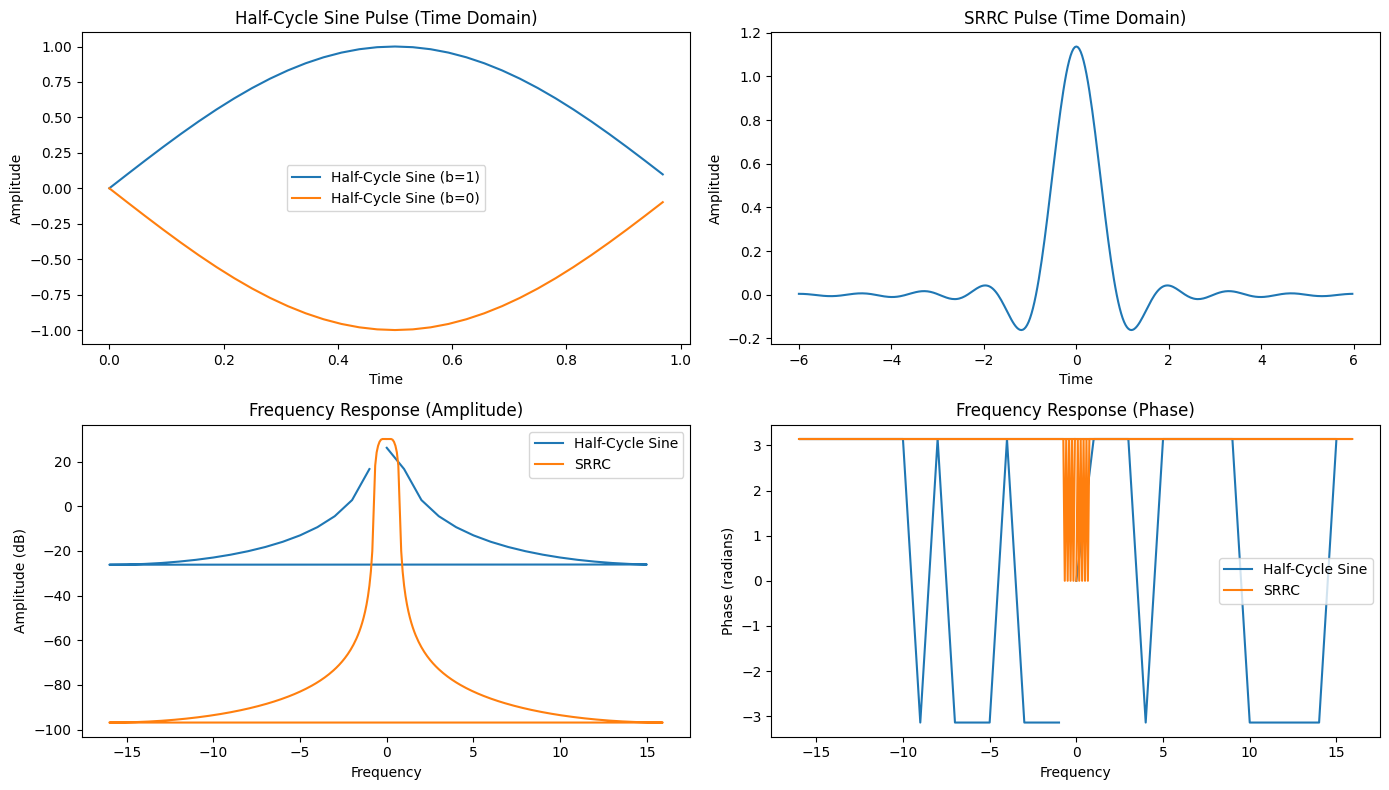

In [5]:
# Parameters
T = 1  # Bit duration
samples_per_bit = 32
t_half = np.linspace(0, T, samples_per_bit, endpoint=False)  # Time for half-cycle sine wave
beta = 0.5  # Roll-off factor for SRRC
K = 6  # Default cutoff length

# Half-Cycle Sine Pulse
g1_pos = np.sin(np.pi * t_half / T)  # For b = 1
g1_neg = -g1_pos  # For b = 0

# SRRC Pulse Generator
def srrc_pulse(t, T, beta):
    numerator = np.sin(np.pi * t / T * (1 - beta)) + \
                4 * beta * t / T * np.cos(np.pi * t / T * (1 + beta))
    denominator = np.pi * t / T * (1 - (4 * beta * t / T)**2)
    # Handle division by zero cases
    denominator[np.isclose(denominator, 0)] = 1  # Avoid division by zero
    pulse = numerator / denominator
    pulse[np.isclose(t, 0)] = 1 - beta + 4 * beta / np.pi  # t = 0 case
    pulse[np.isclose(t, T / (4 * beta))] = beta / np.sqrt(2) * (
        (1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) +
        (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta))
    )  # t = T / (4 * beta)
    pulse[np.isclose(t, -T / (4 * beta))] = beta / np.sqrt(2) * (
        (1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) +
        (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta))
    )  # t = -T / (4 * beta)
    return pulse

# Generate SRRC Pulse
t_srrc = np.linspace(-K * T, K * T, 2 * K * samples_per_bit, endpoint=False)
g2 = srrc_pulse(t_srrc, T, beta)

# Frequency Response
def compute_fft(signal, sampling_rate):
    freq = np.fft.fftfreq(len(signal), d=1 / sampling_rate)
    fft = np.fft.fft(signal)
    amplitude = 20 * np.log10(np.abs(fft))  # Amplitude in dB
    phase = np.angle(fft)
    return freq, amplitude, phase

freq_half, amp_half, phase_half = compute_fft(g1_pos, samples_per_bit / T)
freq_srrc, amp_srrc, phase_srrc = compute_fft(g2, samples_per_bit / T)

# Plotting
plt.figure(figsize=(14, 8))
# Time Domain
plt.subplot(2, 2, 1)
plt.plot(t_half, g1_pos, label="Half-Cycle Sine (b=1)")
plt.plot(t_half, g1_neg, label="Half-Cycle Sine (b=0)")
plt.title("Half-Cycle Sine Pulse (Time Domain)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t_srrc, g2)
plt.title("SRRC Pulse (Time Domain)")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# Frequency Domain
plt.subplot(2, 2, 3)
plt.plot(freq_half, amp_half, label="Half-Cycle Sine")
plt.plot(freq_srrc, amp_srrc, label="SRRC")
plt.title("Frequency Response (Amplitude)")
plt.xlabel("Frequency")
plt.ylabel("Amplitude (dB)")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(freq_half, phase_half, label="Half-Cycle Sine")
plt.plot(freq_srrc, phase_srrc, label="SRRC")
plt.title("Frequency Response (Phase)")
plt.xlabel("Frequency")
plt.ylabel("Phase (radians)")
plt.legend()

plt.tight_layout()
plt.show()


##Question 2: Spectrum of Modulated Signal

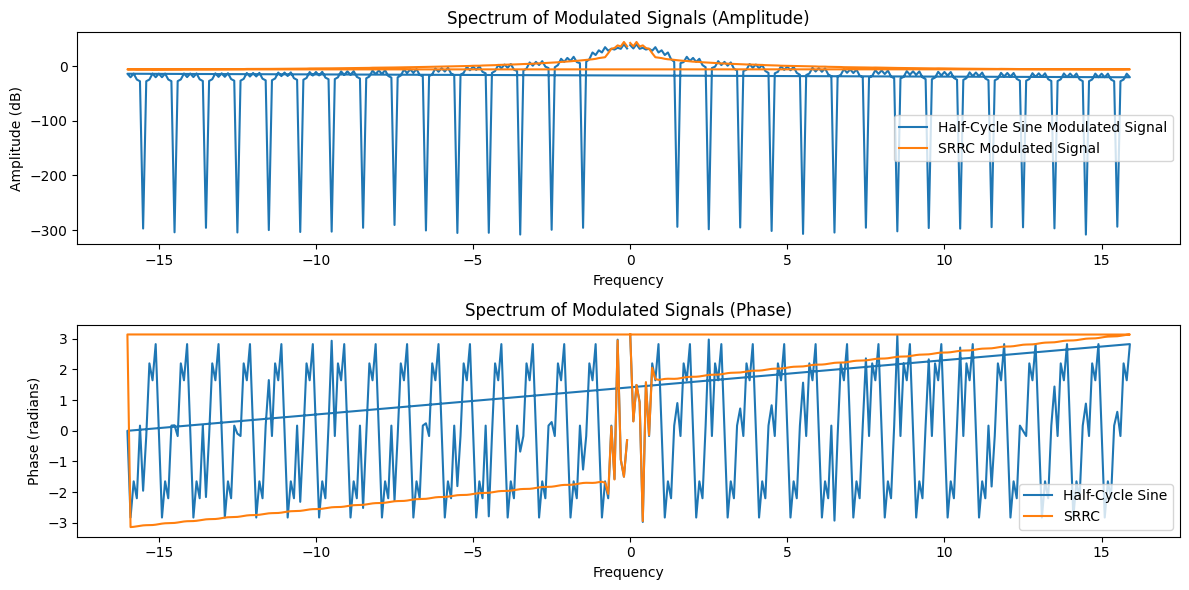

In [6]:
# Question 2: Spectrum of Modulated Signal
num_bits = 10  # Number of random bits
random_bits = np.random.randint(0, 2, num_bits)

# Modulated signal with Half-Cycle Sine Wave
modulated_signal_sine = []
for bit in random_bits:
    pulse = g1_pos if bit == 1 else g1_neg
    modulated_signal_sine.extend(pulse)

# Generate the modulated signal with SRRC (Final Fix)
num_samples_per_bit_srrc = 2 * K * samples_per_bit  # Total samples for each SRRC pulse
modulated_signal_srrc = np.zeros(len(random_bits) * samples_per_bit + num_samples_per_bit_srrc)

for i, bit in enumerate(random_bits):
    # Find the center of the SRRC pulse in the modulated signal
    bit_center_idx = int((i + 0.5) * samples_per_bit)  # Middle of the bit transmission time
    pulse_start_idx = bit_center_idx - num_samples_per_bit_srrc // 2
    pulse_end_idx = bit_center_idx + num_samples_per_bit_srrc // 2

    # Handle edge cases: Clip indices to stay within bounds
    actual_start_idx = max(pulse_start_idx, 0)
    actual_end_idx = min(pulse_end_idx, len(modulated_signal_srrc))
    pulse_start_in_g2 = actual_start_idx - pulse_start_idx
    pulse_end_in_g2 = pulse_start_in_g2 + (actual_end_idx - actual_start_idx)

    # Add the SRRC pulse to the signal
    pulse = g2[pulse_start_in_g2:pulse_end_in_g2] if bit == 1 else -g2[pulse_start_in_g2:pulse_end_in_g2]
    modulated_signal_srrc[actual_start_idx:actual_end_idx] += pulse

# Trim the modulated signal to match the number of bits
modulated_signal_srrc = modulated_signal_srrc[:len(random_bits) * samples_per_bit]


# Compute the spectrum for both modulated signals
freq_mod_sine, amp_mod_sine, phase_mod_sine = compute_fft(modulated_signal_sine, samples_per_bit / T)
freq_mod_srrc, amp_mod_srrc, phase_mod_srrc = compute_fft(modulated_signal_srrc, samples_per_bit / T)

# Plot the spectrum
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_mod_sine, amp_mod_sine, label="Half-Cycle Sine Modulated Signal")
plt.plot(freq_mod_srrc, amp_mod_srrc, label="SRRC Modulated Signal")
plt.title("Spectrum of Modulated Signals (Amplitude)")
plt.xlabel("Frequency")
plt.ylabel("Amplitude (dB)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freq_mod_sine, phase_mod_sine, label="Half-Cycle Sine")
plt.plot(freq_mod_srrc, phase_mod_srrc, label="SRRC")
plt.title("Spectrum of Modulated Signals (Phase)")
plt.xlabel("Frequency")
plt.ylabel("Phase (radians)")
plt.legend()

plt.tight_layout()
plt.show()


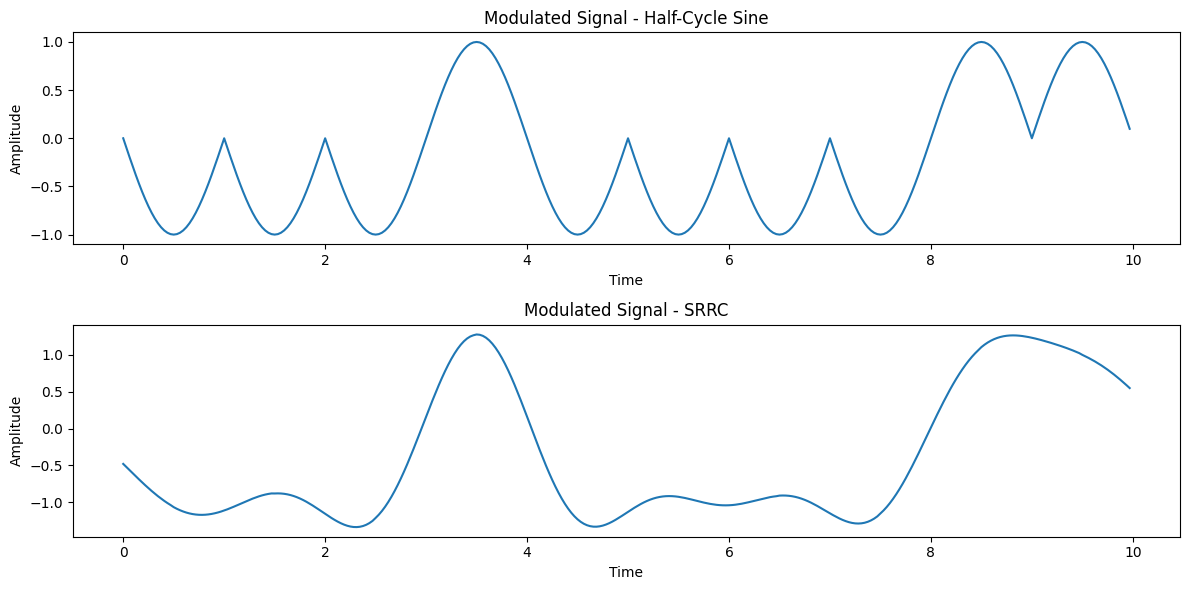

In [7]:
# Question 3: Modulated Signal for Random Bits
time_sine = np.linspace(0, num_bits * T, len(modulated_signal_sine), endpoint=False)
time_srrc = np.linspace(0, num_bits * T, len(modulated_signal_srrc), endpoint=False)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_sine, modulated_signal_sine)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(time_srrc, modulated_signal_srrc)
plt.title("Modulated Signal - SRRC")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


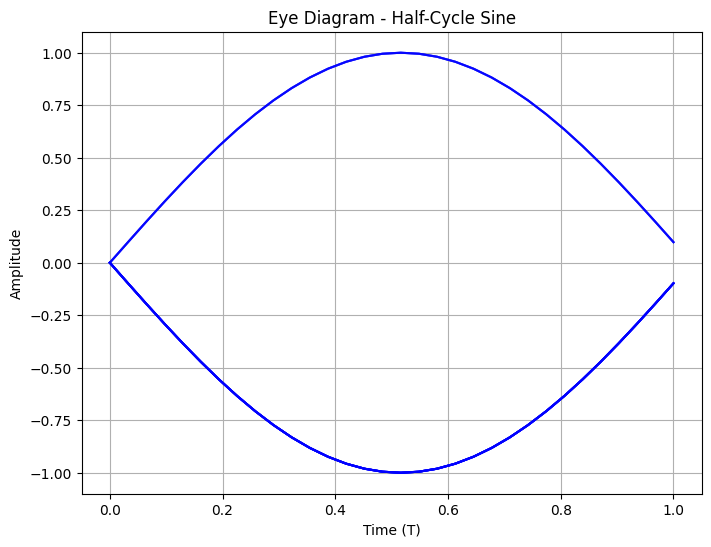

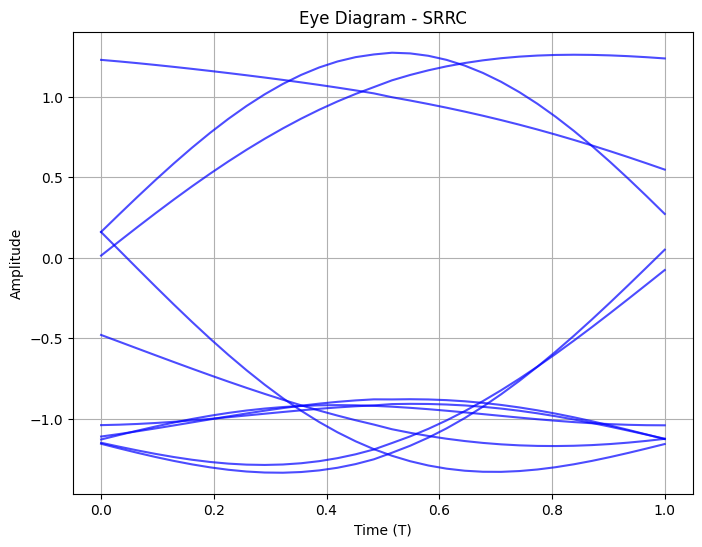

In [8]:
# Convert modulated signals to NumPy arrays
modulated_signal_sine = np.array(modulated_signal_sine)
modulated_signal_srrc = np.array(modulated_signal_srrc)

# Function to plot Eye Diagram
def plot_eye_diagram(signal, samples_per_bit, title):
    # Reshape signal into bit-sized chunks
    bit_chunks = signal[:len(signal) - len(signal) % samples_per_bit].reshape(-1, samples_per_bit)

    plt.figure(figsize=(8, 6))
    for chunk in bit_chunks:
        plt.plot(np.linspace(0, T, samples_per_bit), chunk, color="blue", alpha=0.7)

    plt.title(f"Eye Diagram - {title}")
    plt.xlabel("Time (T)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

# Plot Eye Diagrams
plot_eye_diagram(modulated_signal_sine, samples_per_bit, "Half-Cycle Sine")
plot_eye_diagram(modulated_signal_srrc, samples_per_bit, "SRRC")


#3.4. Channel

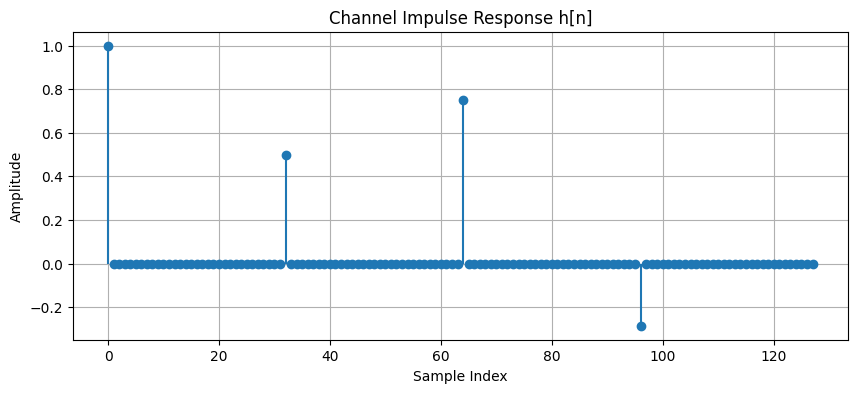

In [9]:
from scipy.signal import freqz

# Parameters
samples_per_bit = 32  # Number of samples per bit
tap_values = [1, 1/2, 3/4, -2/7]  # Tap coefficients
num_taps = len(tap_values)
total_length = 2**int(np.ceil(np.log2((num_taps - 1) * samples_per_bit + 1)))  # Nearest power of 2

# Generate impulse response h[n]
h = np.zeros(total_length)
for i, value in enumerate(tap_values):
    h[i * samples_per_bit] = value

# Plot impulse response
plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(h)), h, basefmt=" ")
plt.title("Channel Impulse Response h[n]")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


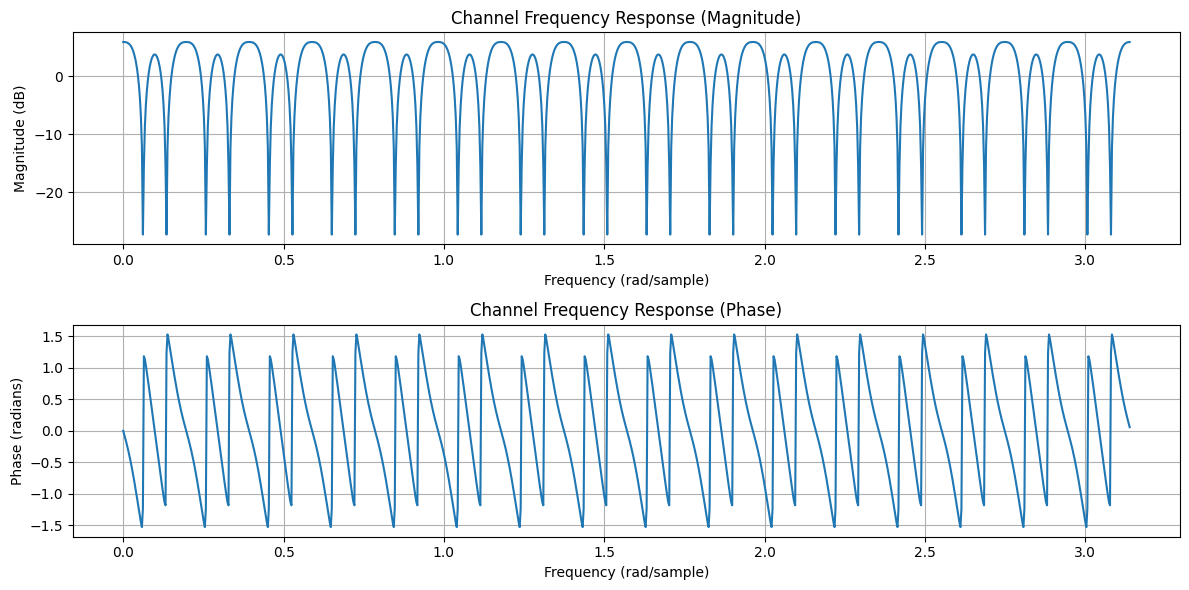

In [10]:
# Compute frequency response
w, H = freqz(h, worN=1024)  # Frequency response

# Plot magnitude and phase
plt.figure(figsize=(12, 6))

# Magnitude
plt.subplot(2, 1, 1)
plt.plot(w, 20 * np.log10(np.abs(H)))
plt.title("Channel Frequency Response (Magnitude)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid()

# Phase
plt.subplot(2, 1, 2)
plt.plot(w, np.angle(H))
plt.title("Channel Frequency Response (Phase)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Phase (radians)")
plt.grid()

plt.tight_layout()
plt.show()


In [88]:
# Convolve modulated signals with channel impulse response
#channel_output_sine = np.convolve(modulated_signal_sine, h, mode='same')
#channel_output_srrc = np.convolve(modulated_signal_srrc, h, mode='same')
#not working right

In [11]:
from scipy.signal import fftconvolve

# FFT-based convolution for modulated signals with channel impulse response
def apply_channel(signal, channel_response):
    # Ensure both signal and channel response are zero-padded to the same length
    fft_size = len(signal) + len(channel_response) - 1
    return np.fft.ifft(
        np.fft.fft(signal, fft_size) * np.fft.fft(channel_response, fft_size)
    ).real[:len(signal)]  # Keep the signal length consistent


In [12]:
# Apply channel to modulated signals
channel_output_sine = apply_channel(modulated_signal_sine, h)
channel_output_srrc = apply_channel(modulated_signal_srrc, h)

Text(0, 0.5, 'Amplitude')

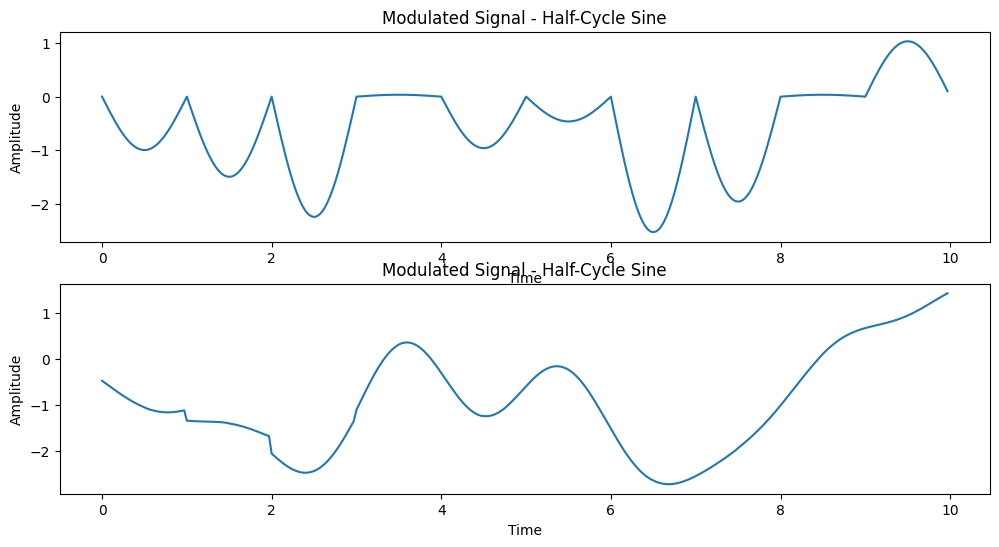

In [13]:
time_srrc = np.linspace(0, num_bits * T, len(modulated_signal_srrc), endpoint=False)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_sine, channel_output_sine)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.subplot(2, 1, 2)
plt.plot(time_sine, channel_output_srrc)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")

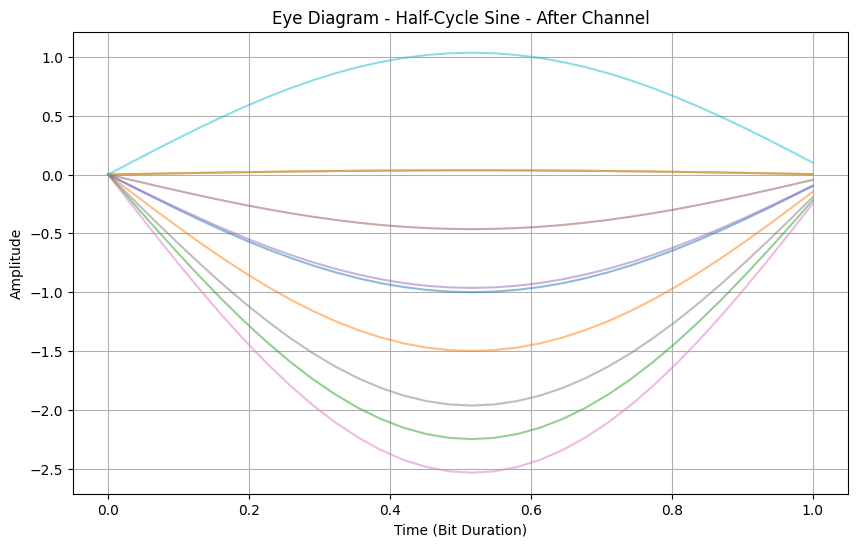

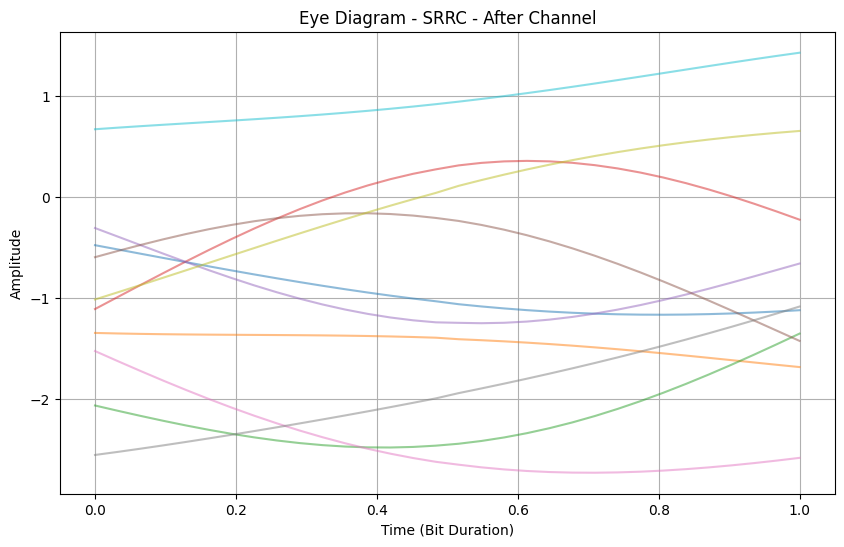

In [14]:
# Function to plot Eye Diagram
def plot_eye_diagram(signal, samples_per_bit, title):
    num_bits = len(signal) // samples_per_bit
    chunks = signal[:num_bits * samples_per_bit].reshape(-1, samples_per_bit)

    plt.figure(figsize=(10, 6))
    for chunk in chunks:
        plt.plot(np.linspace(0, 1, samples_per_bit), chunk, alpha=0.5)

    plt.title(f"Eye Diagram - {title}")
    plt.xlabel("Time (Bit Duration)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

# Plot Eye Diagrams for Channel Outputs
plot_eye_diagram(channel_output_sine, samples_per_bit, "Half-Cycle Sine - After Channel")
plot_eye_diagram(channel_output_srrc, samples_per_bit, "SRRC - After Channel")


#3.5. Noise

In [15]:
# Parameters for noise
noise_power = 0.01  # Example noise power σ^2
sigma = np.sqrt(noise_power)  # Standard deviation of the noise

# Generate Gaussian noise with the same size as the channel outputs
noise_sine = sigma * np.random.randn(len(channel_output_sine))
noise_srrc = sigma * np.random.randn(len(channel_output_srrc))

# Add noise to the channel output
noisy_channel_output_sine = channel_output_sine + noise_sine
noisy_channel_output_srrc = channel_output_srrc + noise_srrc


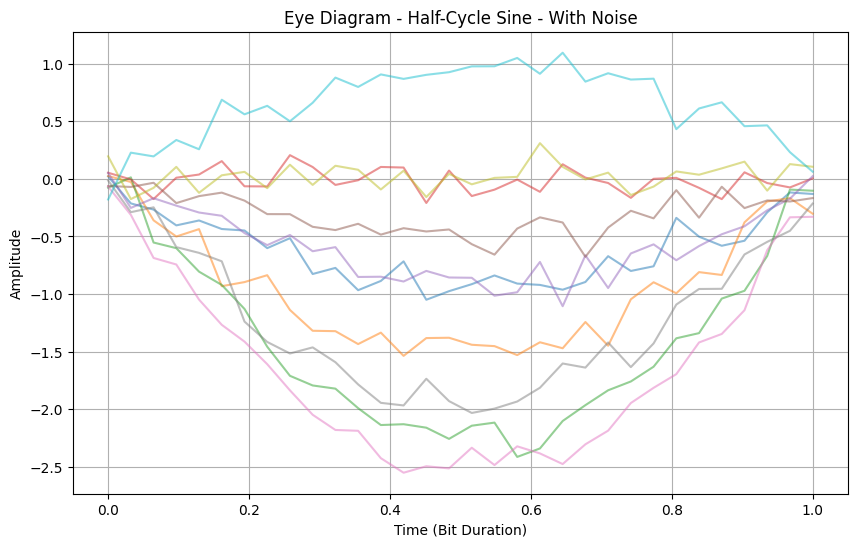

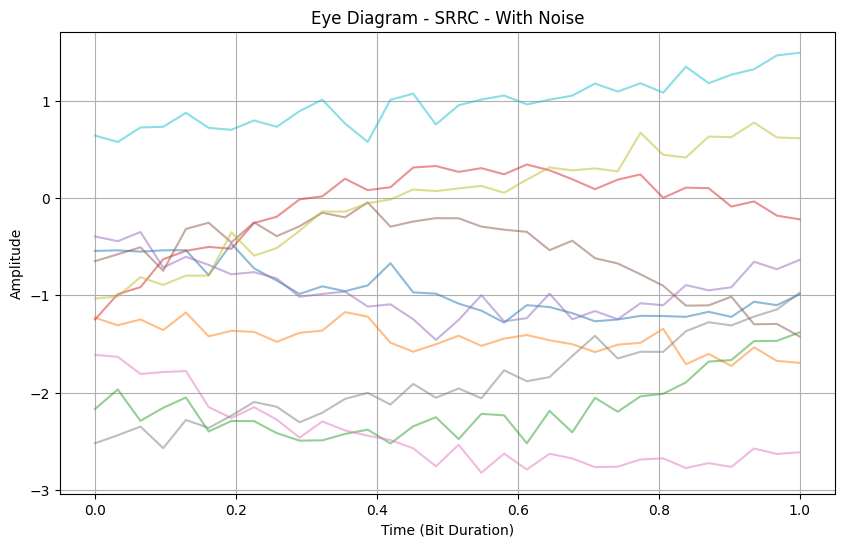

In [16]:
# Plot Eye Diagrams for Noisy Channel Outputs
plot_eye_diagram(noisy_channel_output_sine, samples_per_bit, "Half-Cycle Sine - With Noise")
plot_eye_diagram(noisy_channel_output_srrc, samples_per_bit, "SRRC - With Noise")


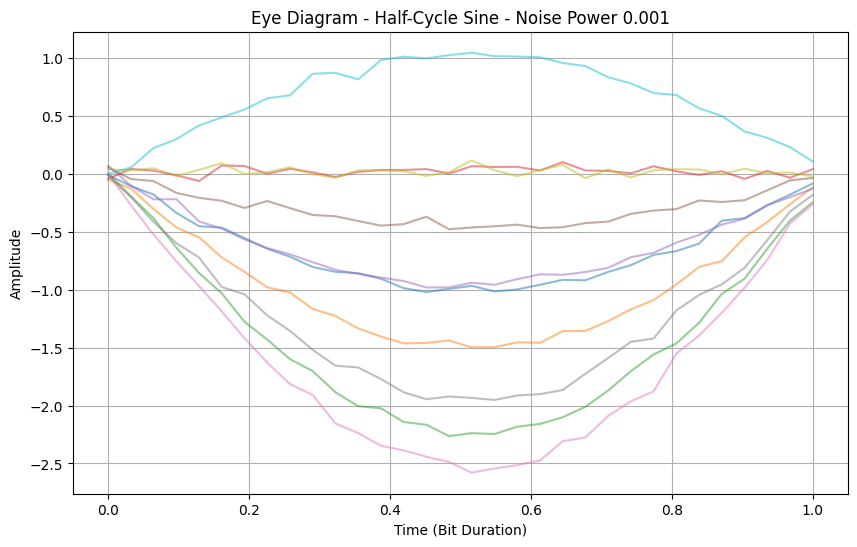

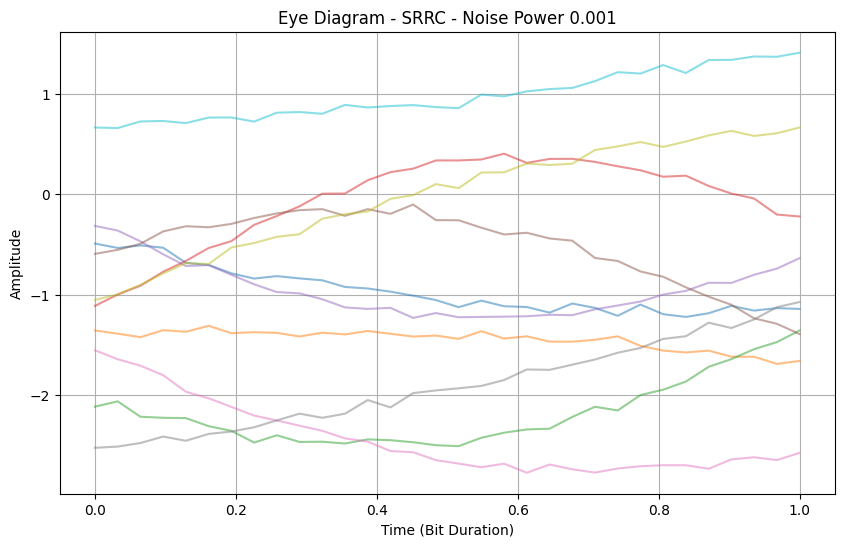

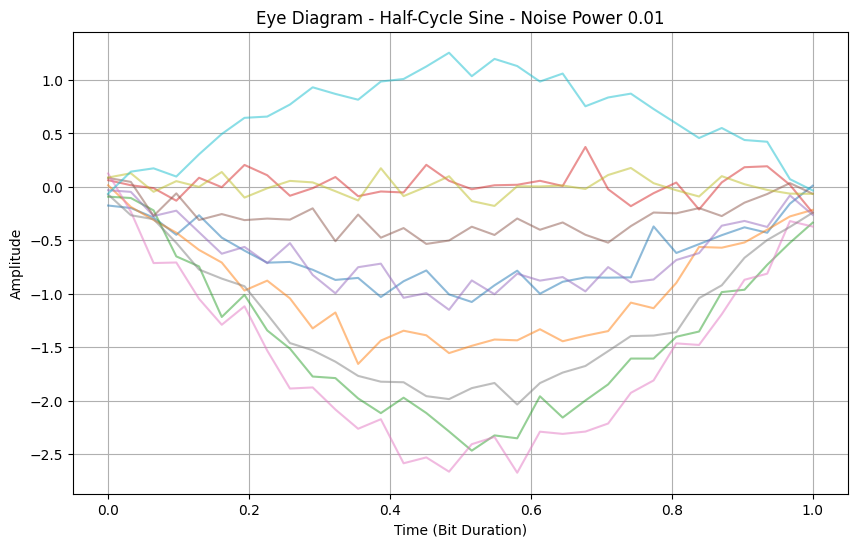

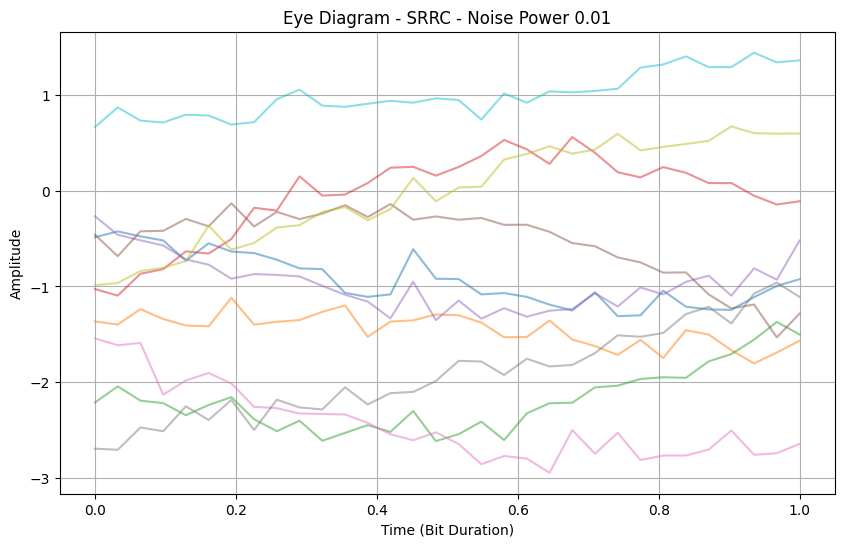

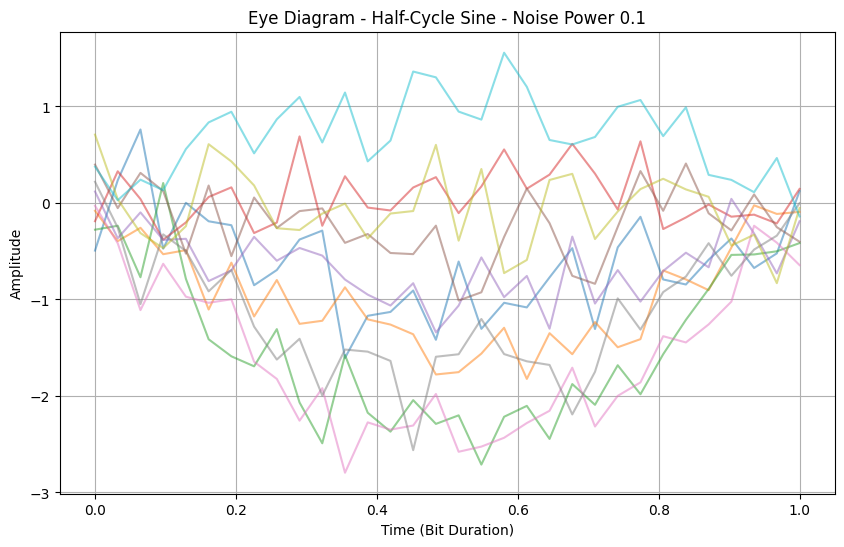

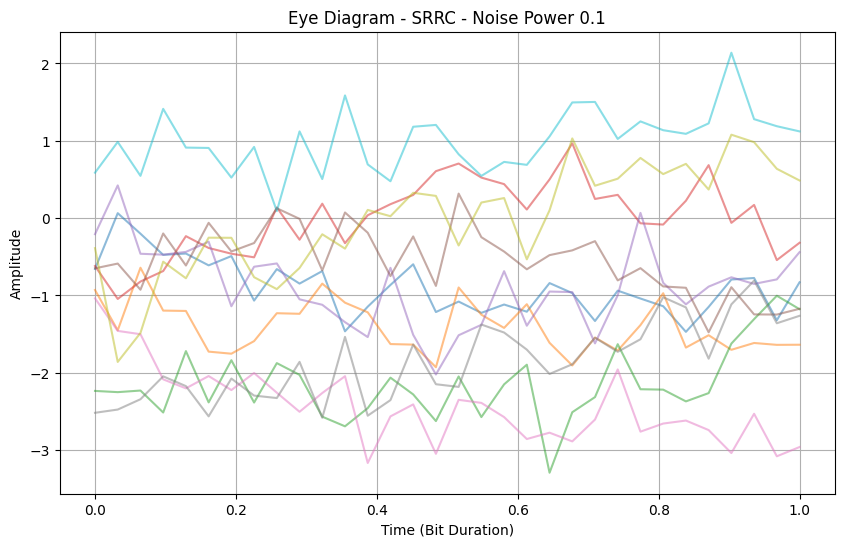

In [17]:
for noise_power in [0.001, 0.01, 0.1]:
    sigma = np.sqrt(noise_power)
    noise_sine = sigma * np.random.randn(len(channel_output_sine))
    noise_srrc = sigma * np.random.randn(len(channel_output_srrc))

    noisy_channel_output_sine = channel_output_sine + noise_sine
    noisy_channel_output_srrc = channel_output_srrc + noise_srrc

    plot_eye_diagram(noisy_channel_output_sine, samples_per_bit, f"Half-Cycle Sine - Noise Power {noise_power}")
    plot_eye_diagram(noisy_channel_output_srrc, samples_per_bit, f"SRRC - Noise Power {noise_power}")


#3.6. Matched Filter

In [18]:
# Matched filter for Half-Cycle Sine
matched_filter_sine = g1_pos[::-1]  # Time-reversed Half-Cycle Sine

def generate_srrc_matched_filter(srrc_pulse, samples_per_bit, K):
    total_samples = len(srrc_pulse)  # Total samples in SRRC pulse
    filter_center = total_samples // 2  # Center of the SRRC pulse
    bit_center = samples_per_bit // 2  # Center of one bit duration

    # Shift the filter so that its center aligns with the middle of the bit
    shift = filter_center - bit_center
    matched_filter = np.roll(srrc_pulse[::-1], -shift)  # Time-reversed SRRC with center alignment
    return matched_filter

# Generate the matched filter
samples_per_bit = len(g2) // (2 * K)  # Calculate samples per bit based on SRRC pulse
matched_filter_srrc = generate_srrc_matched_filter(g2, samples_per_bit, K)

# matched_filter_srrc = g2[::-1] =? Time-reversed SRRC pulse is wrong

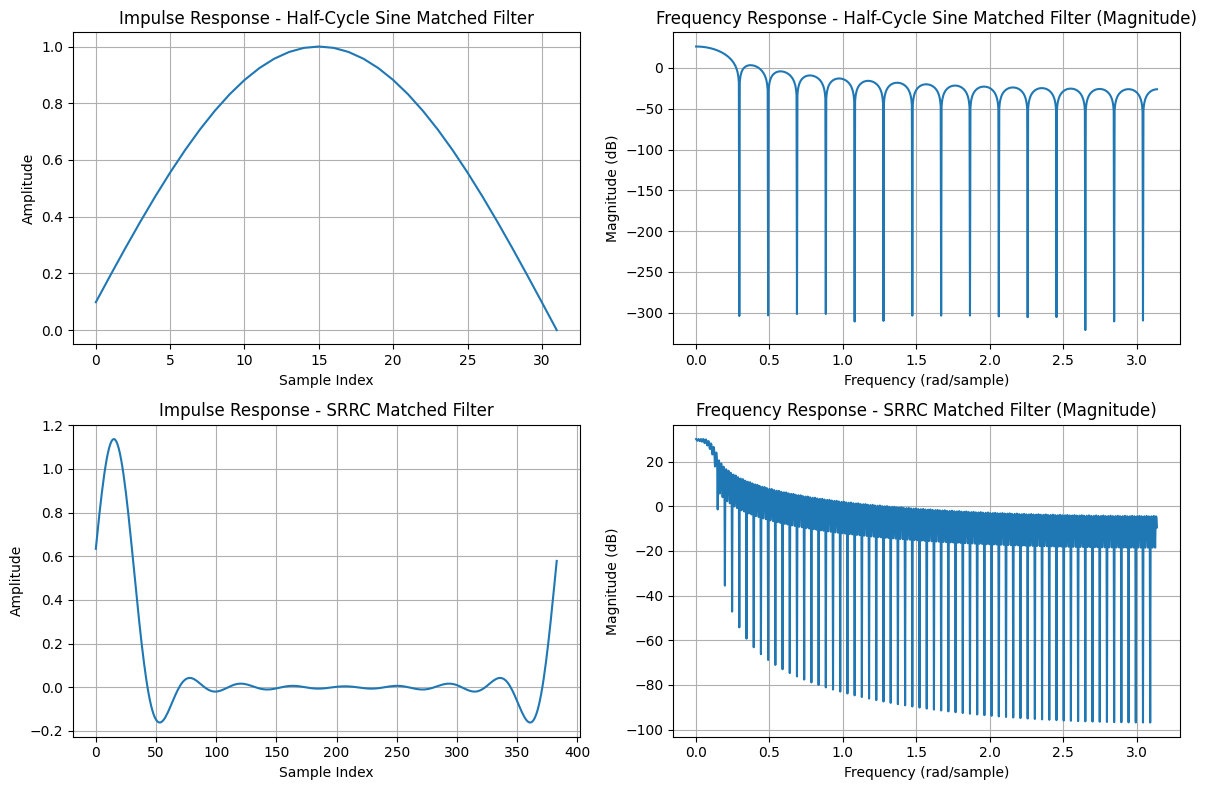

In [19]:
# Compute frequency responses
w_sine, H_sine = freqz(matched_filter_sine, worN=1024)
w_srrc, H_srrc = freqz(matched_filter_srrc, worN=1024)

# Plot impulse response and frequency response for both matched filters
plt.figure(figsize=(12, 8))

# Impulse Response for Half-Cycle Sine
plt.subplot(2, 2, 1)
plt.plot(matched_filter_sine)
plt.title("Impulse Response - Half-Cycle Sine Matched Filter")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()

# Frequency Response for Half-Cycle Sine
plt.subplot(2, 2, 2)
plt.plot(w_sine, 20 * np.log10(np.abs(H_sine)))
plt.title("Frequency Response - Half-Cycle Sine Matched Filter (Magnitude)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid()

# Impulse Response for SRRC
plt.subplot(2, 2, 3)
plt.plot(matched_filter_srrc)
plt.title("Impulse Response - SRRC Matched Filter")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()

# Frequency Response for SRRC
plt.subplot(2, 2, 4)
plt.plot(w_srrc, 20 * np.log10(np.abs(H_srrc)))
plt.title("Frequency Response - SRRC Matched Filter (Magnitude)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid()

plt.tight_layout()
plt.show()


In [20]:
# Apply matched filter to the noisy channel outputs
filtered_output_sine = apply_channel(noisy_channel_output_sine, matched_filter_sine)
filtered_output_srrc = apply_channel(noisy_channel_output_srrc, matched_filter_srrc)

Text(0, 0.5, 'Amplitude')

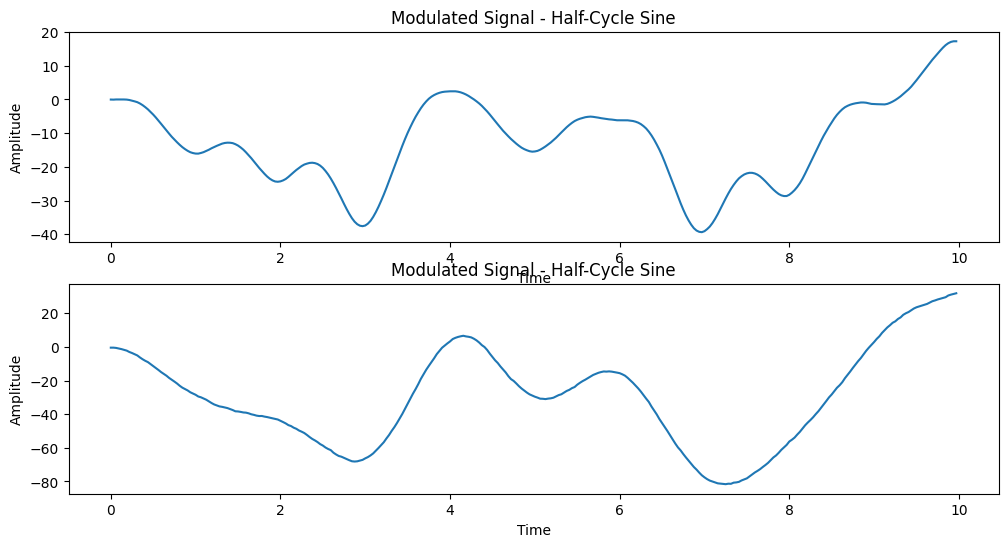

In [21]:
time_srrc = np.linspace(0, num_bits * T, len(modulated_signal_srrc), endpoint=False)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_sine, filtered_output_sine)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.subplot(2, 1, 2)
plt.plot(time_sine, filtered_output_srrc)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")

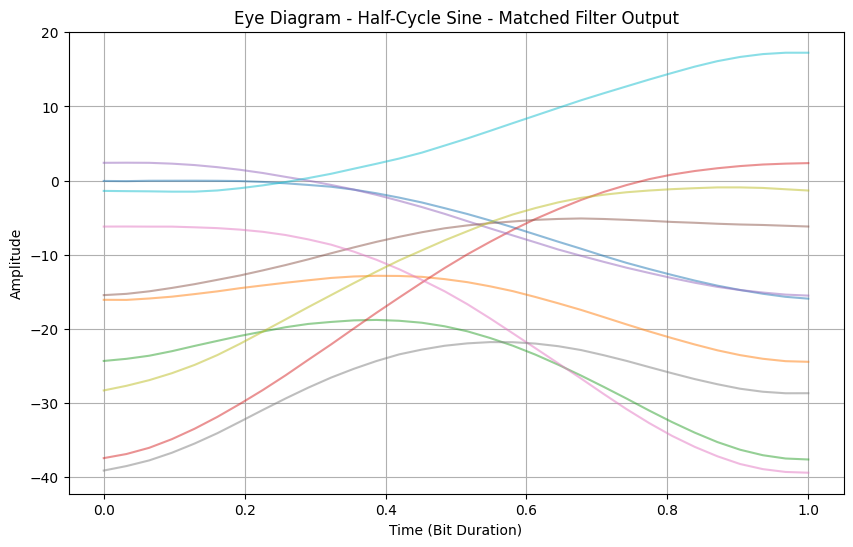

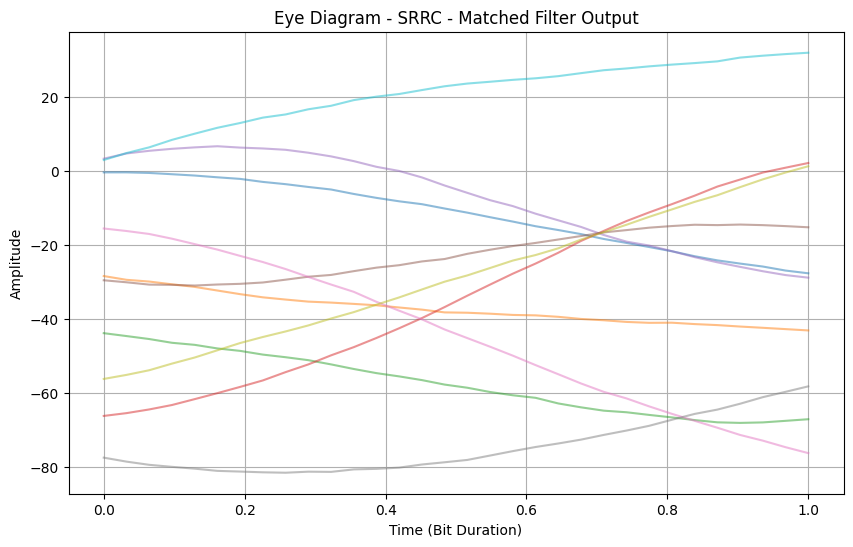

In [22]:
# Plot Eye Diagrams for Matched Filter Outputs
plot_eye_diagram(filtered_output_sine, samples_per_bit, "Half-Cycle Sine - Matched Filter Output")
plot_eye_diagram(filtered_output_srrc, samples_per_bit, "SRRC - Matched Filter Output")


#3.7. Compensator

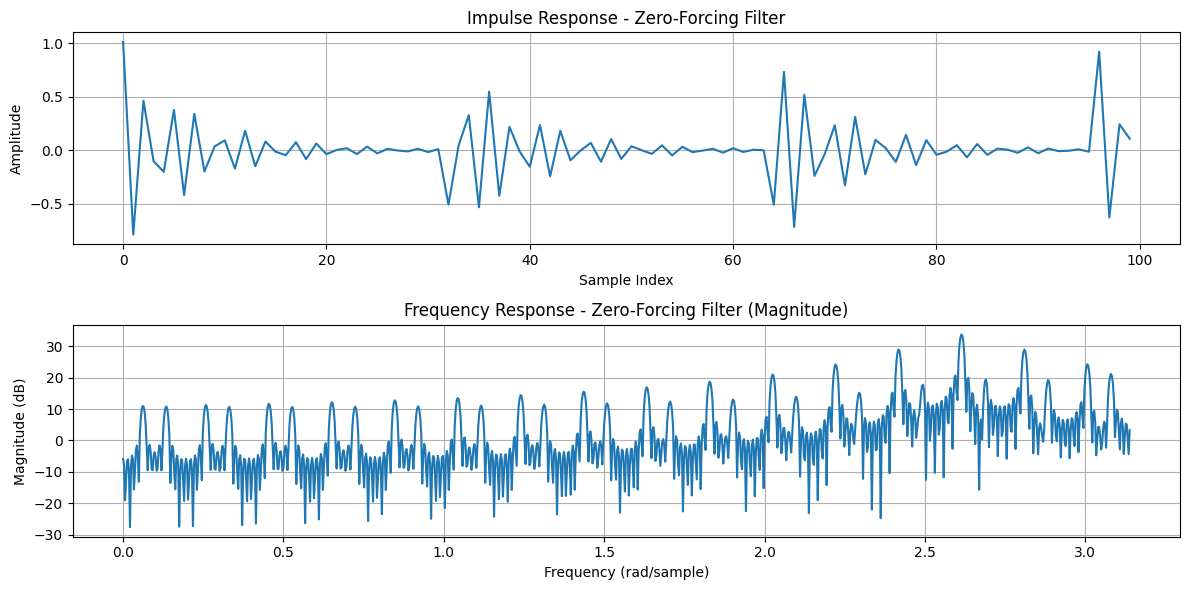

In [23]:
# Parameters
fft_size = len(h)+ len(filtered_output_sine)-1  # Ensure sufficient FFT size

# FFT of the channel impulse response
H = np.fft.fft(h, n=fft_size)

H_inv = 1 / H  # Zero-Forcing filter frequency response

# Avoid division by zero or small values (stability enhancement)
H_inv[np.abs(H) < 1e-9] = 0

# FFT of the matched filter outputs
filtered_sine_fft = np.fft.fft(filtered_output_sine, n=fft_size)
filtered_srrc_fft = np.fft.fft(filtered_output_srrc, n=fft_size)

# Apply ZF equalizer
zf_output_sine = np.fft.ifft(filtered_sine_fft * H_inv).real[:len(filtered_output_sine)]
zf_output_srrc = np.fft.ifft(filtered_srrc_fft * H_inv).real[:len(filtered_output_srrc)]

zf_filter = np.fft.ifft(H_inv).real

# Plot the impulse and frequency response of the ZF filter
w_zf, H_zf = freqz(zf_filter, worN=1024)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(zf_filter[:100])  # Plot first 100 samples for clarity
plt.title("Impulse Response - Zero-Forcing Filter")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(w_zf, 20 * np.log10(np.abs(H_zf)))
plt.title("Frequency Response - Zero-Forcing Filter (Magnitude)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid()

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Amplitude')

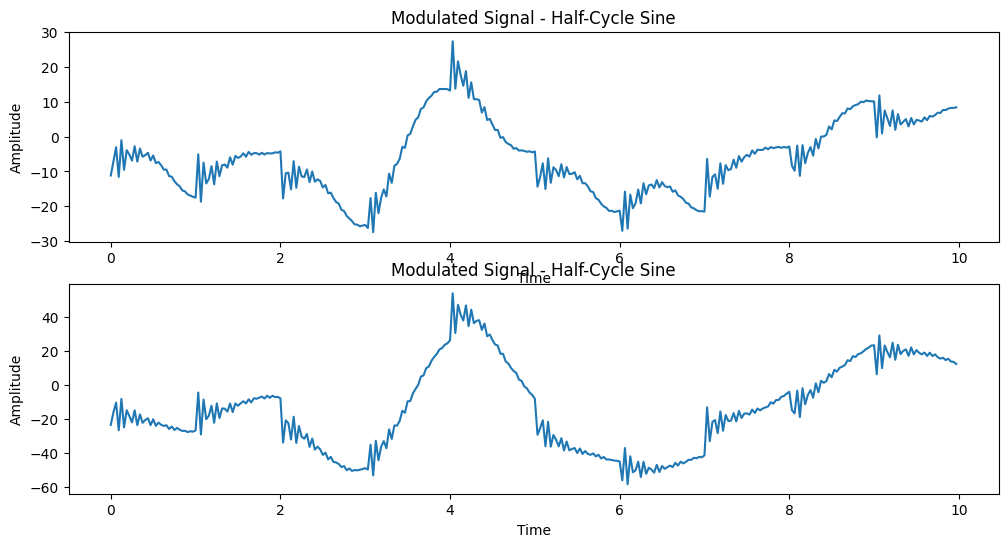

In [24]:
time_srrc = np.linspace(0, num_bits * T, len(modulated_signal_srrc), endpoint=False)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_sine, zf_output_sine)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.subplot(2, 1, 2)
plt.plot(time_sine, zf_output_srrc)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")

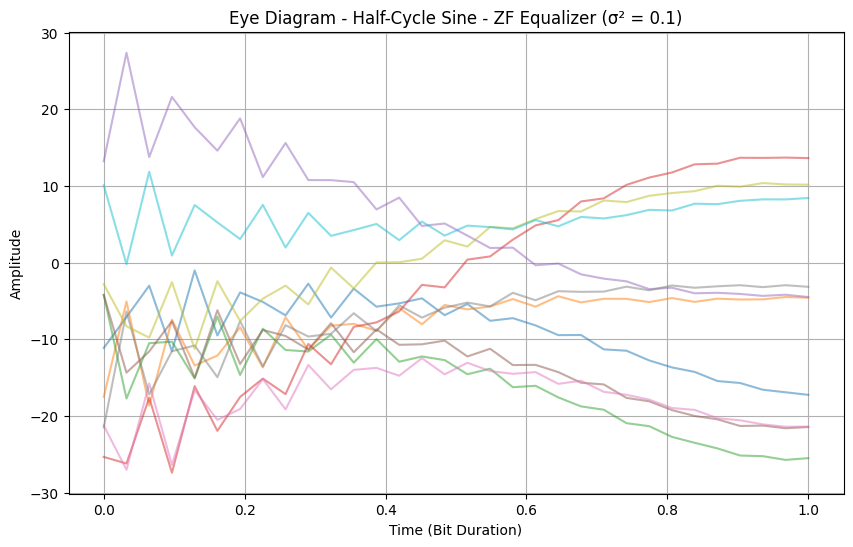

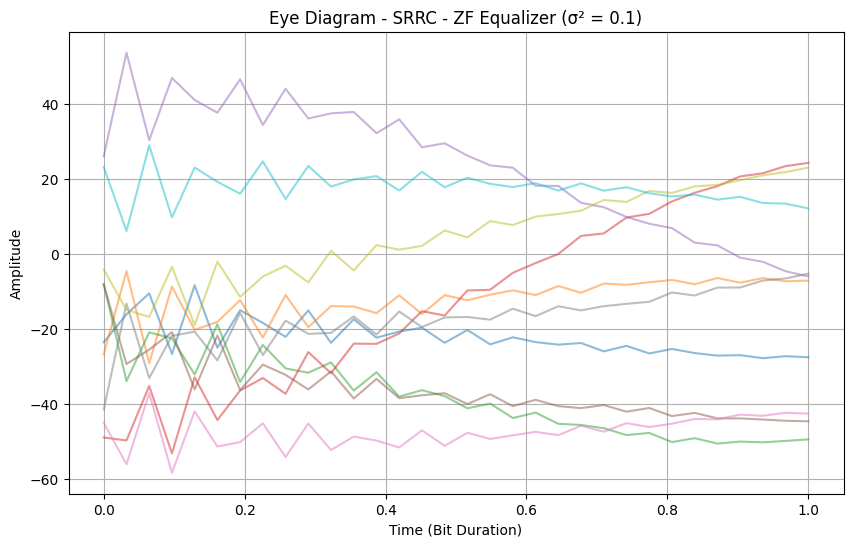

In [25]:
# Plot Eye Diagrams for ZF Filter Output
plot_eye_diagram(zf_output_sine, samples_per_bit, "Half-Cycle Sine - ZF Equalizer (σ² = {})".format(noise_power))
plot_eye_diagram(zf_output_srrc, samples_per_bit, "SRRC - ZF Equalizer (σ² = {})".format(noise_power))

#3.7.2. MMSE Equalizer

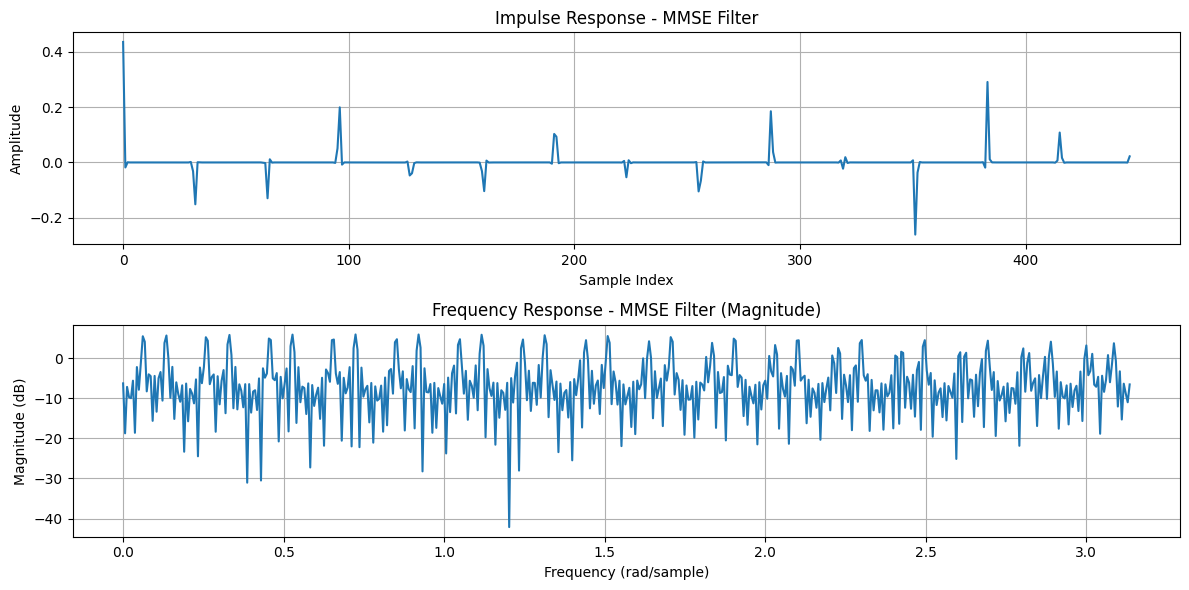

In [26]:
# Compute MMSE filter frequency response
H_conj = np.conj(H)  # Conjugate of the channel response
mmse_filter_freq = H_conj / (np.abs(H)**2 + 2 * noise_power)  # MMSE filter frequency response

# Impulse response of the MMSE filter
mmse_filter = np.fft.ifft(mmse_filter_freq, n=fft_size).real

# Apply the MMSE filter to the matched filter outputs
mmse_output_sine = apply_channel(filtered_output_sine, mmse_filter)
mmse_output_srrc = apply_channel(filtered_output_srrc, mmse_filter)

# Plot impulse and frequency response of the MMSE filter
w_mmse, H_mmse = freqz(mmse_filter)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(mmse_filter)
plt.title("Impulse Response - MMSE Filter")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(w_mmse, 20 * np.log10(np.abs(H_mmse)))
plt.title("Frequency Response - MMSE Filter (Magnitude)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid()

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Amplitude')

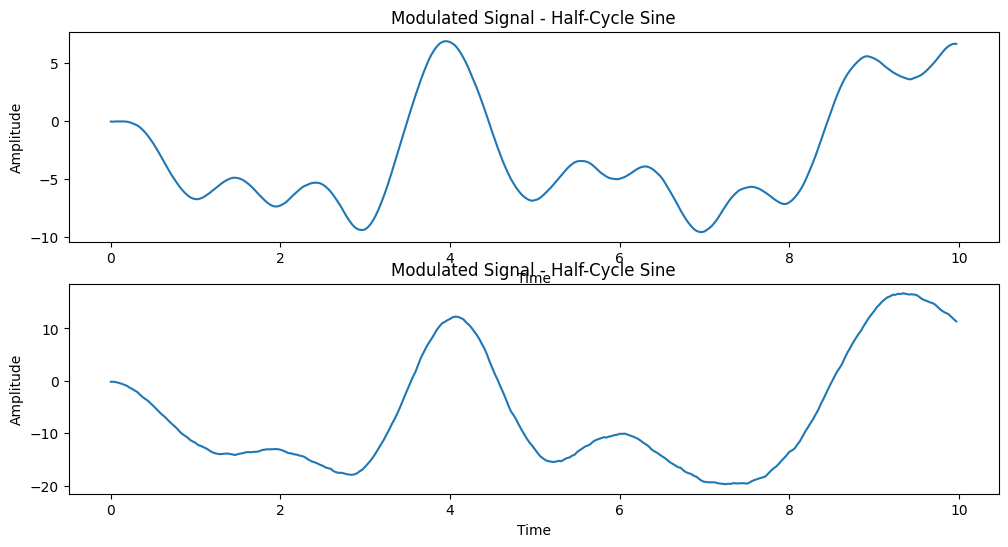

In [27]:
time_srrc = np.linspace(0, num_bits * T, len(modulated_signal_srrc), endpoint=False)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_sine, mmse_output_sine)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.subplot(2, 1, 2)
plt.plot(time_sine, mmse_output_srrc)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

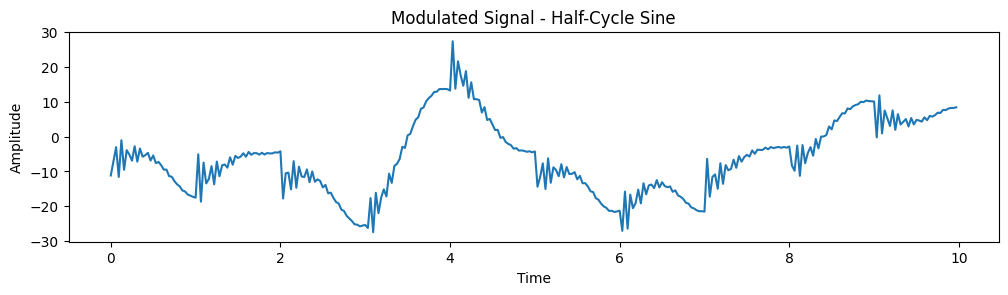

In [28]:
time_srrc = np.linspace(0, num_bits * T, len(modulated_signal_srrc), endpoint=False)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_sine, zf_output_sine)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

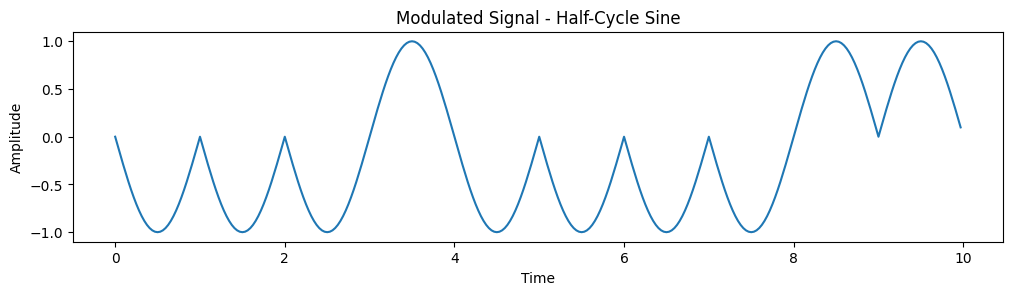

In [29]:
time_srrc = np.linspace(0, num_bits * T, len(modulated_signal_srrc), endpoint=False)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_sine, modulated_signal_sine)
plt.title("Modulated Signal - Half-Cycle Sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")

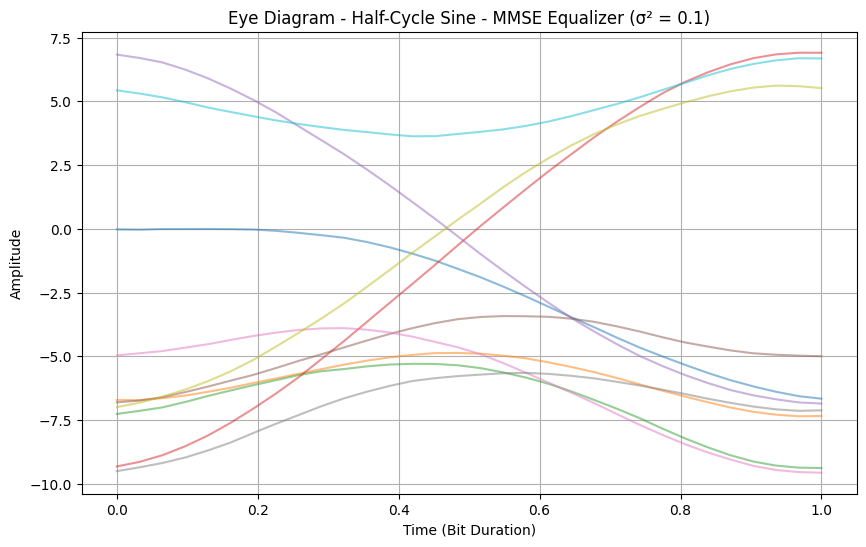

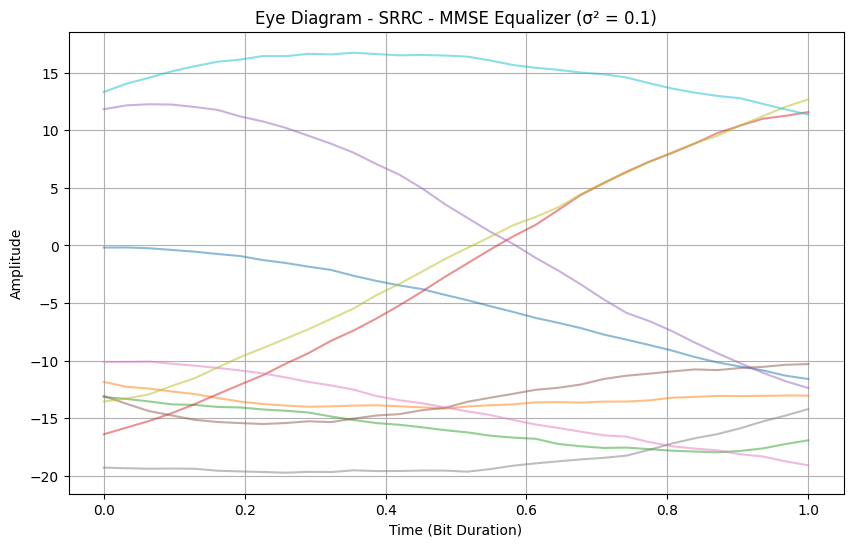

In [30]:
# Plot Eye Diagrams for MMSE Filter Output
plot_eye_diagram(mmse_output_sine, samples_per_bit, "Half-Cycle Sine - MMSE Equalizer (σ² = {})".format(noise_power))
plot_eye_diagram(mmse_output_srrc, samples_per_bit, "SRRC - MMSE Equalizer (σ² = {})".format(noise_power))


#3.8. Sampling and Identification

In [31]:
def sample_and_identify(signal, samples_per_bit, num_blocks):
    # Find the start time (assume the first bit is at the maximum amplitude for simplicity)
    start_time = np.argmax(np.abs(signal[:samples_per_bit]))  # Peak detection for first bit

    # Sample the signal
    sampled_bits = []
    for i in range(num_blocks * 8):  # num_blocks * 8 bits (1 block = 8 bits)
        sample_index = start_time + i * samples_per_bit
        if sample_index >= len(signal):  # Avoid out-of-bounds error
            break
        sampled_bits.append(1 if signal[sample_index] > 0 else 0)

    # Convert to a bit matrix (n rows, 8 bits per row)
    valid_bits = len(sampled_bits) // 8 * 8  # Ensure multiple of 8 bits
    bit_matrix = np.array(sampled_bits[:valid_bits]).reshape(-1, 8)

    return bit_matrix

In [32]:
def reconstruct_image_from_bitstream(bit_rows, scale_consts, m, n):

    dct_min, dct_max = scale_consts

    # 1) Convert bits back to integer values (0..255)
    recovered_bytes = np.packbits(bit_rows, axis=1).flatten()  # shape => (64*N,)

    # 2) Reshape to 8&times;8&times;N
    total_values = recovered_bytes.shape[0]
    N = total_values // 64  # number of 8x8 blocks
    recovered_3d = recovered_bytes.reshape((8, 8, N))

    # 3) Undo the [0..1] scaling back to original DCT range
    recovered_scaled = recovered_3d.astype(np.float64) / 255.0
    recovered_dct = recovered_scaled * (dct_max - dct_min) + dct_min

    # 4) Perform the inverse DCT on each 8&times;8 block
    #    First transpose to (N, 8, 8) to make iteration simpler
    rec_dct_reshaped = np.transpose(recovered_dct, (2, 0, 1))  # shape => (N, 8, 8)
    rec_blocks = np.zeros_like(rec_dct_reshaped)
    for b in range(N):
        rec_blocks[b] = idct(idct(rec_dct_reshaped[b], axis=0, norm='ortho'), axis=1, norm='ortho')

    # 5) Reassemble blocks into the final 2D image
    rec_blocks = rec_blocks.reshape((m // 8, n // 8, 8, 8))
    rec_img = np.zeros((m, n), dtype=np.float64)

    # Place each recovered 8&times;8 block into the correct position
    for i in range(m // 8):
        for j in range(n // 8):
            rec_img[i*8:(i+1)*8, j*8:(j+1)*8] = rec_blocks[i, j]

    # Clip to [0..1] to prevent any out-of-bound values
    rec_img = np.clip(rec_img, 0, 1)

    # Convert back to [0..255] as uint8
    rec_img_uint8 = (rec_img * 255).astype(np.uint8)

    return rec_img_uint8


In [33]:
def sample_and_identify2(signal, samples_per_bit):
    # Find the start time (assume the first bit is at the maximum amplitude for simplicity)
    start_time = np.argmax(np.abs(signal[:samples_per_bit]))  # Peak detection for first bit

    # Sample the signal
    sampled_bits = []
    for i in range(10):  # num_blocks * 8 bits (1 block = 8 bits)
        sample_index = start_time + i * samples_per_bit
        if sample_index >= len(signal):  # Avoid out-of-bounds error
            break
        sampled_bits.append(1 if signal[sample_index] > 0 else 0)


    return sampled_bits

In [34]:
# Sampling and Identification
bit_matrix1 = sample_and_identify2(signal=zf_output_sine, samples_per_bit=samples_per_bit)
bit_matrix2 = sample_and_identify2(signal=zf_output_srrc, samples_per_bit=samples_per_bit)
bit_matrix3 = sample_and_identify2(signal=mmse_output_sine, samples_per_bit=samples_per_bit)
bit_matrix4 = sample_and_identify2(signal=mmse_output_srrc, samples_per_bit=samples_per_bit)

In [35]:
print(bit_matrix1)
print(bit_matrix2)
print(bit_matrix3)
print(bit_matrix4)

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 1]


#3.10 Image Reconstruction

In [36]:
final_bitstream = np.load("final_bitstream.npy")

In [77]:
# Define modulation for Half-Cycle Sine
modulated_signal_sine = []
for bit in final_bitstream.flatten():
    pulse = g1_pos if bit == 1 else g1_neg
    modulated_signal_sine.extend(pulse)

# Convolve the signal with the channel
channel_output_sine = apply_channel(modulated_signal_sine, h)

# Add Gaussian noise
noise_power = 0.05
noise = np.sqrt(noise_power) * np.random.randn(len(channel_output_sine))
noisy_channel_output_sine = channel_output_sine + noise

# Apply matched filter
filtered_output_sine = apply_channel(noisy_channel_output_sine, matched_filter_sine)

# Parameters
fft_size = len(h)+ len(filtered_output_sine)-1  # Ensure sufficient FFT size

# FFT of the channel impulse response
H = np.fft.fft(h, n=fft_size)

H_inv = 1 / H  # Zero-Forcing filter frequency response

# Avoid division by zero or small values (stability enhancement)
H_inv[np.abs(H) < 1e-9] = 0
zf_filter = np.fft.ifft(H_inv, n=fft_size).real

# Apply ZF equalizer
zf_output_sine = apply_channel(filtered_output_sine, zf_filter)

# Compute MMSE filter frequency response
H_conj = np.conj(H)  # Conjugate of the channel response
mmse_filter_freq = H_conj / (np.abs(H)**2 + 2 * noise_power)  # MMSE filter frequency response

# Impulse response of the MMSE filter
mmse_filter = np.fft.ifft(mmse_filter_freq, n=fft_size).real

# Apply the MMSE filter to the matched filter outputs
mmse_output_sine = apply_channel(filtered_output_sine, mmse_filter)



# Sampling and Identification
bit_matrix_decoded_sine_zf = sample_and_identify(zf_output_sine, samples_per_bit, 50176)

bit_matrix_decoded_sine_mmse = sample_and_identify(mmse_output_sine, samples_per_bit, 50176)


reconstructed_img_sine_zf = reconstruct_image_from_bitstream(bit_matrix_decoded_sine_zf, scale_consts, m, n)

reconstructed_img_sine_mmse = reconstruct_image_from_bitstream(bit_matrix_decoded_sine_mmse, scale_consts, m, n)

In [88]:
num_error_bit = np.sum(np.abs(bit_matrix_decoded_sine_zf-final_bitstream))
snr_dB = 10 * np.log10(np.mean(zf_output_sine**2)/noise_power)

print(num_error_bit)
print(snr_dB)

49
35.03973004748718


In [82]:
num_error_bit = np.sum(np.abs(bit_matrix_decoded_sine_mmse-final_bitstream))
snr_dB = 10 * np.log10(np.mean(mmse_output_sine**2)/noise_power)

print(num_error_bit)
print(snr_dB)

19
29.180041489226056


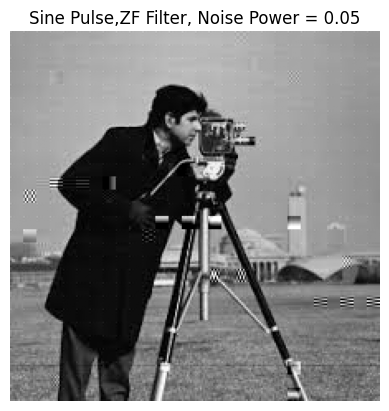

In [89]:
plt.imshow(reconstructed_img_sine_zf,cmap = 'gray')
plt.axis('off')
plt.title('Sine Pulse,ZF Filter, Noise Power = 0.05', fontsize=12)
plt.show()

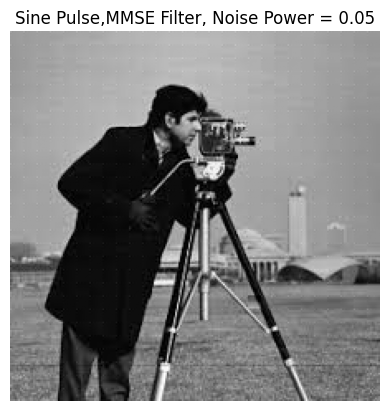

In [90]:
plt.imshow(reconstructed_img_sine_mmse,cmap = 'gray')
plt.axis('off')
plt.title('Sine Pulse,MMSE Filter, Noise Power = 0.05', fontsize=12)
plt.show()

In [65]:
# Generate the modulated signal with SRRC (Final Fix)
num_samples_per_bit_srrc = 2 * K * samples_per_bit  # Total samples for each SRRC pulse
modulated_signal_srrc = np.zeros(len(final_bitstream.flatten()) * samples_per_bit + num_samples_per_bit_srrc)

for i, bit in enumerate(final_bitstream.flatten()):
    # Find the center of the SRRC pulse in the modulated signal
    bit_center_idx = int((i + 0.5) * samples_per_bit)  # Middle of the bit transmission time
    pulse_start_idx = bit_center_idx - num_samples_per_bit_srrc // 2
    pulse_end_idx = bit_center_idx + num_samples_per_bit_srrc // 2

    # Handle edge cases: Clip indices to stay within bounds
    actual_start_idx = max(pulse_start_idx, 0)
    actual_end_idx = min(pulse_end_idx, len(modulated_signal_srrc))
    pulse_start_in_g2 = actual_start_idx - pulse_start_idx
    pulse_end_in_g2 = pulse_start_in_g2 + (actual_end_idx - actual_start_idx)

    # Add the SRRC pulse to the signal
    pulse = g2[pulse_start_in_g2:pulse_end_in_g2] if bit == 1 else -g2[pulse_start_in_g2:pulse_end_in_g2]
    modulated_signal_srrc[actual_start_idx:actual_end_idx] += pulse

# Trim the modulated signal to match the number of bits
modulated_signal_srrc = modulated_signal_srrc[:len(final_bitstream.flatten()) * samples_per_bit]

# Convolve the signal with the channel
channel_output_srrc = apply_channel(modulated_signal_srrc, h)

# Add Gaussian noise
noise_power = 0.03
noise = np.sqrt(noise_power) * np.random.randn(len(channel_output_srrc))
noisy_channel_output_srrc = channel_output_srrc + noise

# Apply matched filter
filtered_output_srrc = apply_channel(noisy_channel_output_srrc, matched_filter_srrc)

# Parameters
fft_size = len(h)+ len(filtered_output_srrc)-1  # Ensure sufficient FFT size

# FFT of the channel impulse response
H = np.fft.fft(h, n=fft_size)

H_inv = 1 / H  # Zero-Forcing filter frequency response

# Avoid division by zero or small values (stability enhancement)
H_inv[np.abs(H) < 1e-9] = 0
zf_filter = np.fft.ifft(H_inv, n=fft_size).real

# Apply ZF equalizer
zf_output_srrc = apply_channel(filtered_output_srrc, zf_filter)


# Compute MMSE filter frequency response
H_conj = np.conj(H)  # Conjugate of the channel response
mmse_filter_freq = H_conj / (np.abs(H)**2 + 2 * noise_power)  # MMSE filter frequency response

# Impulse response of the MMSE filter
mmse_filter = np.fft.ifft(mmse_filter_freq, n=fft_size).real

# Apply the MMSE filter to the matched filter outputs
mmse_output_srrc = apply_channel(filtered_output_srrc, mmse_filter)



# Sampling and Identification
bit_matrix_decoded_srrc_zf = sample_and_identify(zf_output_srrc, samples_per_bit, 50176)

bit_matrix_decoded_srrc_mmse = sample_and_identify(mmse_output_srrc, samples_per_bit, 50176)


reconstructed_img_srrc_zf = reconstruct_image_from_bitstream(bit_matrix_decoded_srrc_zf, scale_consts, m, n)

reconstructed_img_srrc_mmse = reconstruct_image_from_bitstream(bit_matrix_decoded_srrc_mmse, scale_consts, m, n)


In [69]:
num_error_bit = np.sum(np.abs(bit_matrix_decoded_srrc_mmse-final_bitstream))
snr_dB = 10 * np.log10(np.mean(channel_output_sine**2)/noise_power)

print(num_error_bit)
print(snr_dB)

2
15.390506062344729


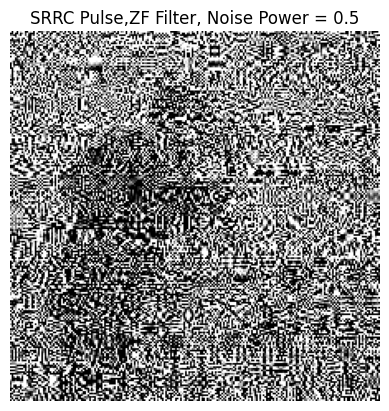

In [63]:
plt.imshow(reconstructed_img_srrc_zf,cmap = 'gray')
plt.axis('off')
plt.title('SRRC Pulse,ZF Filter, Noise Power = 0.5', fontsize=12)
plt.show()

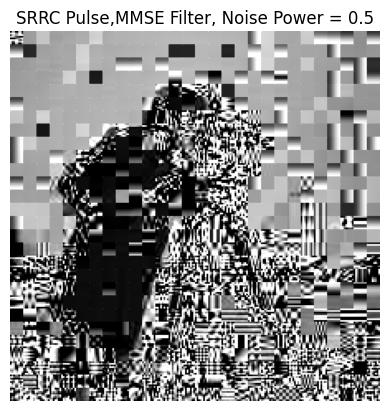

In [64]:
plt.imshow(reconstructed_img_srrc_mmse,cmap = 'gray')
plt.axis('off')
plt.title('SRRC Pulse,MMSE Filter, Noise Power = 0.5', fontsize=12)
plt.show()

In [40]:
# --- Step 1: Load image, convert to double, and check dimensions ---
# Replace 'example.png' with your image filename.
img = cv2.imread('Smile.png', cv2.IMREAD_GRAYSCALE)
m, n = img.shape
m -= m % 8
n -= n % 8
img = img[:m, :n]


# Ensure the dimensions are divisible by 8
assert m % 8 == 0 and n % 8 == 0, "Image dimensions must be divisible by 8."

# Convert image from [0..255] to float64 in [0..1]
img_float = img.astype(np.float64) / 255.0

# --- Step 2: Partition the image into 8&times;8 blocks ---
# This will create a view with shape = (m//8, n//8, 8, 8)
blocks = view_as_blocks(img_float, block_shape=(8,8))

# Create an array to store the DCT results with the same shape
dct_blocks = np.zeros_like(blocks)

# --- Step 3: Perform the 2D DCT on each 8&times;8 block ---
for i in range(blocks.shape[0]):
    for j in range(blocks.shape[1]):
        # Apply DCT in both directions with 'ortho' normalization
        dct_blocks[i, j] = dct(dct(blocks[i, j], axis=0, norm='ortho'), axis=1, norm='ortho')

# --- Step 4: Convert the DCT values to a [0..1] scale ---
dct_min = np.min(dct_blocks)
dct_max = np.max(dct_blocks)
scaled_dct = (dct_blocks - dct_min) / (dct_max - dct_min)

# Save these scaling constants for later use in reconstruction
scale_consts = (dct_min, dct_max)

# --- Step 5: Quantize the scaled DCT to 8 bits (0..255) ---
quantized_dct = np.round(scaled_dct * 255).astype(np.uint8)

# --- Step 6: Reshape to 3D array of size 8&times;8&times;(m*n/64) ---
num_blocks = (m // 8) * (n // 8)
# After reshape: shape becomes (num_blocks, 8, 8)
quantized_blocks_reshaped = quantized_dct.reshape(num_blocks, 8, 8)
# Now permute to shape (8, 8, num_blocks)
quantized_dct_3d = np.transpose(quantized_blocks_reshaped, (1, 2, 0))

print("Step 1 complete.")
print("quantized_dct_3d shape =", quantized_dct_3d.shape)

Step 1 complete.
quantized_dct_3d shape = (8, 8, 784)


In [41]:
N = 784
start_block = 0
bitstream = blocks_to_bitstream(quantized_dct_3d, start_block, N)
# Save the bitstream to a file
np.save("final_bitstream2.npy", bitstream)

print(f"Bitstream conversion completed with group size N = {N}.")

print("bitstream shape =", bitstream.shape, " -> (64*N, 8) =", 64*N, "&times;", 8)


Bitstream conversion completed with group size N = 784.
bitstream shape = (50176, 8)  -> (64*N, 8) = 50176 &times; 8


In [43]:
final_bitstream2 = np.load("final_bitstream2.npy")

In [44]:
# Define modulation for Half-Cycle Sine
modulated_signal_sine = []
for bit in final_bitstream2.flatten():
    pulse = g1_pos if bit == 1 else g1_neg
    modulated_signal_sine.extend(pulse)

# Convolve the signal with the channel
channel_output_sine = apply_channel(modulated_signal_sine, h)

# Add Gaussian noise
noise_power = 0.05
noise = np.sqrt(noise_power) * np.random.randn(len(channel_output_sine))
noisy_channel_output_sine = channel_output_sine + noise

# Apply matched filter
filtered_output_sine = apply_channel(noisy_channel_output_sine, matched_filter_sine)

# Parameters
fft_size = len(h)+ len(filtered_output_sine)-1  # Ensure sufficient FFT size

# FFT of the channel impulse response
H = np.fft.fft(h, n=fft_size)

H_inv = 1 / H  # Zero-Forcing filter frequency response

# Avoid division by zero or small values (stability enhancement)
H_inv[np.abs(H) < 1e-9] = 0
zf_filter = np.fft.ifft(H_inv, n=fft_size).real

# Apply ZF equalizer
zf_output_sine = apply_channel(filtered_output_sine, zf_filter)

# Compute MMSE filter frequency response
H_conj = np.conj(H)  # Conjugate of the channel response
mmse_filter_freq = H_conj / (np.abs(H)**2 + 2 * noise_power)  # MMSE filter frequency response

# Impulse response of the MMSE filter
mmse_filter = np.fft.ifft(mmse_filter_freq, n=fft_size).real

# Apply the MMSE filter to the matched filter outputs
mmse_output_sine = apply_channel(filtered_output_sine, mmse_filter)



# Sampling and Identification
bit_matrix_decoded_sine_zf = sample_and_identify(zf_output_sine, samples_per_bit, 50176)

bit_matrix_decoded_sine_mmse = sample_and_identify(mmse_output_sine, samples_per_bit, 50176)


reconstructed_img_sine_zf = reconstruct_image_from_bitstream(bit_matrix_decoded_sine_zf, scale_consts, m, n)

reconstructed_img_sine_mmse = reconstruct_image_from_bitstream(bit_matrix_decoded_sine_mmse, scale_consts, m, n)

88
35.25788282754736
37
29.16846907888432


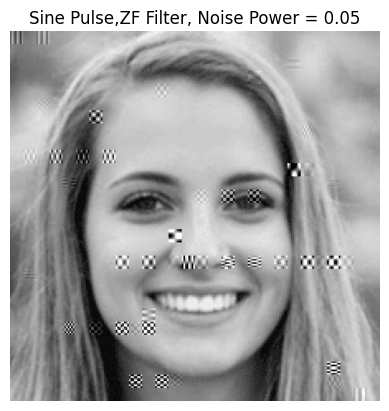

In [46]:
num_error_bit = np.sum(np.abs(bit_matrix_decoded_sine_zf-final_bitstream2))
snr_dB = 10 * np.log10(np.mean(zf_output_sine**2)/noise_power)

print(num_error_bit)
print(snr_dB)
num_error_bit = np.sum(np.abs(bit_matrix_decoded_sine_mmse-final_bitstream2))
snr_dB = 10 * np.log10(np.mean(mmse_output_sine**2)/noise_power)

print(num_error_bit)
print(snr_dB)
plt.imshow(reconstructed_img_sine_zf,cmap = 'gray')
plt.axis('off')
plt.title('Sine Pulse,ZF Filter, Noise Power = 0.05', fontsize=12)
plt.show()


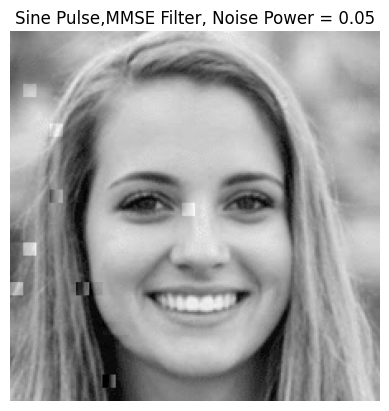

In [47]:
plt.imshow(reconstructed_img_sine_mmse,cmap = 'gray')
plt.axis('off')
plt.title('Sine Pulse,MMSE Filter, Noise Power = 0.05', fontsize=12)
plt.show()

#4.4. Channel Effects

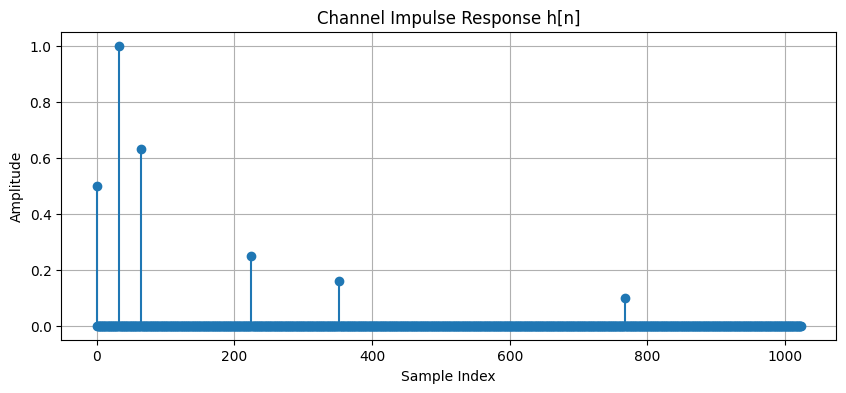

In [38]:
# Parameters
samples_per_bit = 32  # Number of samples per bit
tap_values = [0.5, 1, 0.63, 0, 0, 0, 0, 0.25, 0, 0, 0, 0.16, 0,0,0,0,0,0,0,0,0,0,0,0,0.1]  # Tap coefficients
num_taps = len(tap_values)
total_length = 2**int(np.ceil(np.log2((num_taps - 1) * samples_per_bit + 1)))  # Nearest power of 2

# Generate impulse response h[n]
h1 = np.zeros(total_length)
for i, value in enumerate(tap_values):
    h1[i * samples_per_bit] = value

# Plot impulse response
plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(h1)), h1, basefmt=" ")
plt.title("Channel Impulse Response h[n]")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

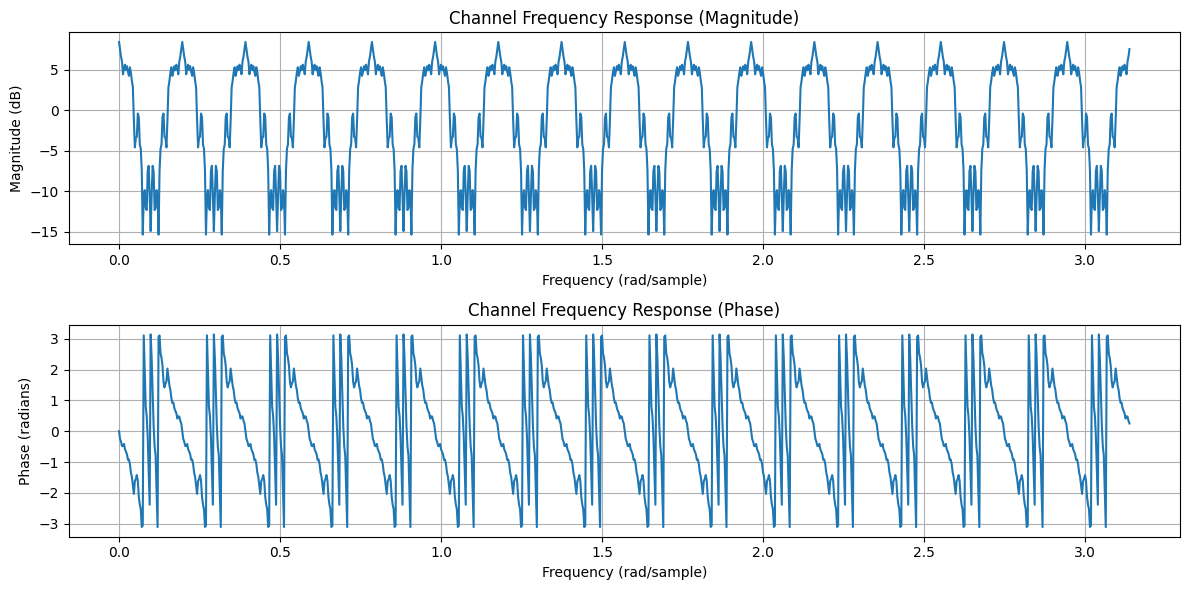

In [39]:
# Compute frequency response
w, H = freqz(h1, worN=1024)  # Frequency response

# Plot magnitude and phase
plt.figure(figsize=(12, 6))

# Magnitude
plt.subplot(2, 1, 1)
plt.plot(w, 20 * np.log10(np.abs(H)))
plt.title("Channel Frequency Response (Magnitude)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid()

# Phase
plt.subplot(2, 1, 2)
plt.plot(w, np.angle(H))
plt.title("Channel Frequency Response (Phase)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Phase (radians)")
plt.grid()

plt.tight_layout()
plt.show()

In [50]:
# Define modulation for Half-Cycle Sine
modulated_signal_sine = []
for bit in final_bitstream.flatten():
    pulse = g1_pos if bit == 1 else g1_neg
    modulated_signal_sine.extend(pulse)

# Convolve the signal with the channel
channel_output_sine = apply_channel(modulated_signal_sine, h1)

# Add Gaussian noise
noise_power = 0.0
noise = np.sqrt(noise_power) * np.random.randn(len(channel_output_sine))
noisy_channel_output_sine = channel_output_sine + noise

# Apply matched filter
filtered_output_sine = apply_channel(noisy_channel_output_sine, matched_filter_sine)

# Parameters
fft_size = len(h1)+ len(filtered_output_sine)-1  # Ensure sufficient FFT size

# FFT of the channel impulse response
H = np.fft.fft(h1, n=fft_size)

H_inv = 1 / H  # Zero-Forcing filter frequency response

# Avoid division by zero or small values (stability enhancement)
H_inv[np.abs(H) < 1e-9] = 0
zf_filter = np.fft.ifft(H_inv, n=fft_size).real

# Apply ZF equalizer
zf_output_sine = apply_channel(filtered_output_sine, zf_filter)

# Compute MMSE filter frequency response
H_conj = np.conj(H)  # Conjugate of the channel response
mmse_filter_freq = H_conj / (np.abs(H)**2 + 2 * noise_power)  # MMSE filter frequency response

# Impulse response of the MMSE filter
mmse_filter = np.fft.ifft(mmse_filter_freq, n=fft_size).real

# Apply the MMSE filter to the matched filter outputs
mmse_output_sine = apply_channel(filtered_output_sine, mmse_filter)



# Sampling and Identification
bit_matrix_decoded_sine_zf = sample_and_identify(zf_output_sine, samples_per_bit, 50176)

bit_matrix_decoded_sine_mmse = sample_and_identify(mmse_output_sine, samples_per_bit, 50176)


reconstructed_img_sine_zf = reconstruct_image_from_bitstream(bit_matrix_decoded_sine_zf, scale_consts, m, n)

reconstructed_img_sine_mmse = reconstruct_image_from_bitstream(bit_matrix_decoded_sine_mmse, scale_consts, m, n)

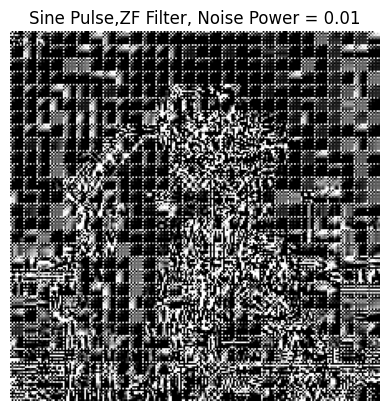

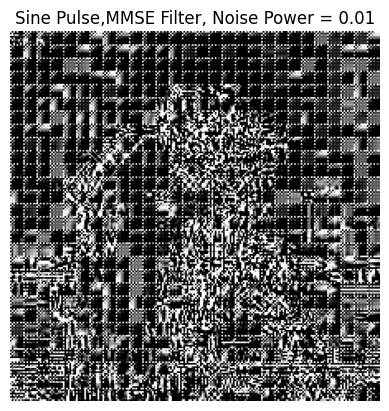

In [53]:
plt.imshow(reconstructed_img_sine_zf,cmap = 'gray')
plt.axis('off')
plt.title('Sine Pulse,ZF Filter, Noise Power = 0.01', fontsize=12)
plt.show()
plt.imshow(reconstructed_img_sine_mmse,cmap = 'gray')
plt.axis('off')
plt.title('Sine Pulse,MMSE Filter, Noise Power = 0.01', fontsize=12)
plt.show()


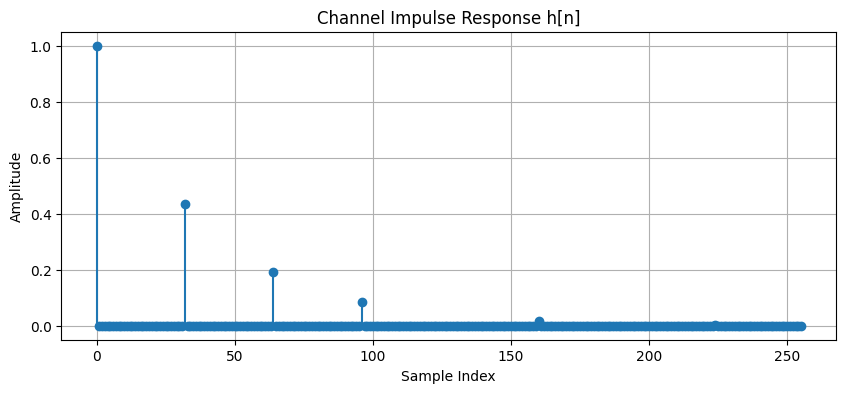

In [46]:
# Parameters
samples_per_bit = 32  # Number of samples per bit
tap_values = [1,0.4365,0.1905,0.0832,0,0.0158,0,0.003]  # Tap coefficients
num_taps = len(tap_values)
total_length = 2**int(np.ceil(np.log2((num_taps - 1) * samples_per_bit + 1)))  # Nearest power of 2

# Generate impulse response h[n]
h2 = np.zeros(total_length)
for i, value in enumerate(tap_values):
    h2[i * samples_per_bit] = value

# Plot impulse response
plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(h2)), h2, basefmt=" ")
plt.title("Channel Impulse Response h[n]")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

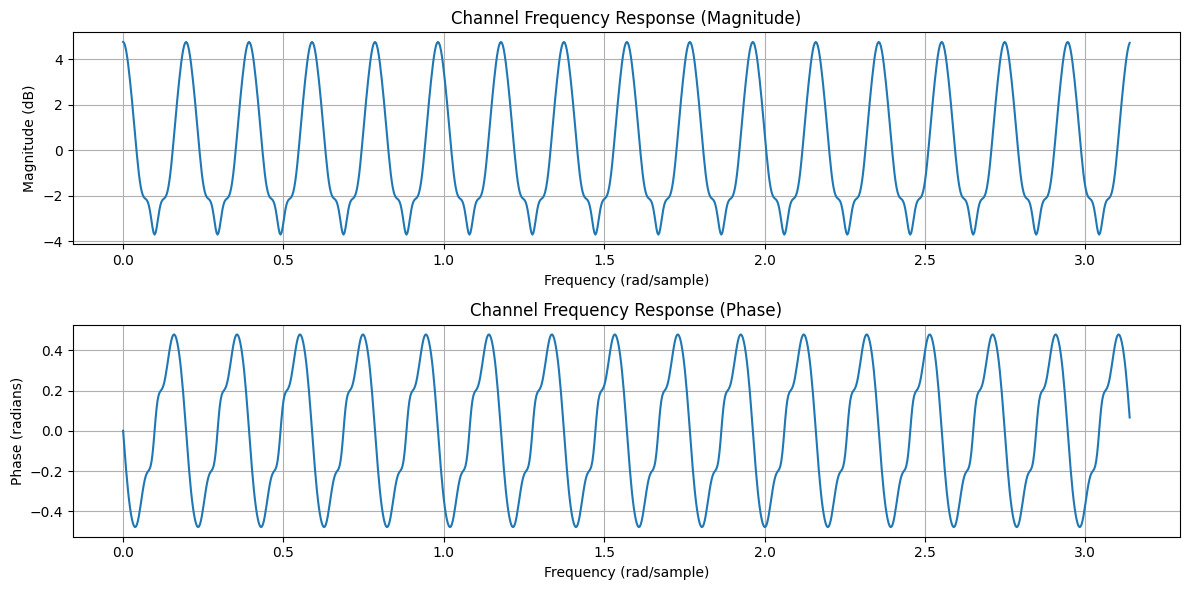

In [47]:
# Compute frequency response
w, H = freqz(h2, worN=1024)  # Frequency response

# Plot magnitude and phase
plt.figure(figsize=(12, 6))

# Magnitude
plt.subplot(2, 1, 1)
plt.plot(w, 20 * np.log10(np.abs(H)))
plt.title("Channel Frequency Response (Magnitude)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.grid()

# Phase
plt.subplot(2, 1, 2)
plt.plot(w, np.angle(H))
plt.title("Channel Frequency Response (Phase)")
plt.xlabel("Frequency (rad/sample)")
plt.ylabel("Phase (radians)")
plt.grid()

plt.tight_layout()
plt.show()

In [48]:
# Define modulation for Half-Cycle Sine
modulated_signal_sine = []
for bit in final_bitstream.flatten():
    pulse = g1_pos if bit == 1 else g1_neg
    modulated_signal_sine.extend(pulse)

# Convolve the signal with the channel
channel_output_sine = apply_channel(modulated_signal_sine, h2)

# Add Gaussian noise
noise_power = 0.01
noise = np.sqrt(noise_power) * np.random.randn(len(channel_output_sine))
noisy_channel_output_sine = channel_output_sine + noise

# Apply matched filter
filtered_output_sine = apply_channel(noisy_channel_output_sine, matched_filter_sine)

# Parameters
fft_size = len(h2)+ len(filtered_output_sine)-1  # Ensure sufficient FFT size

# FFT of the channel impulse response
H = np.fft.fft(h2, n=fft_size)

H_inv = 1 / H  # Zero-Forcing filter frequency response

# Avoid division by zero or small values (stability enhancement)
H_inv[np.abs(H) < 1e-9] = 0
zf_filter = np.fft.ifft(H_inv, n=fft_size).real

# Apply ZF equalizer
zf_output_sine = apply_channel(filtered_output_sine, zf_filter)

# Compute MMSE filter frequency response
H_conj = np.conj(H)  # Conjugate of the channel response
mmse_filter_freq = H_conj / (np.abs(H)**2 + 2 * noise_power)  # MMSE filter frequency response

# Impulse response of the MMSE filter
mmse_filter = np.fft.ifft(mmse_filter_freq, n=fft_size).real

# Apply the MMSE filter to the matched filter outputs
mmse_output_sine = apply_channel(filtered_output_sine, mmse_filter)



# Sampling and Identification
bit_matrix_decoded_sine_zf = sample_and_identify(zf_output_sine, samples_per_bit, 50176)

bit_matrix_decoded_sine_mmse = sample_and_identify(mmse_output_sine, samples_per_bit, 50176)


reconstructed_img_sine_zf = reconstruct_image_from_bitstream(bit_matrix_decoded_sine_zf, scale_consts, m, n)

reconstructed_img_sine_mmse = reconstruct_image_from_bitstream(bit_matrix_decoded_sine_mmse, scale_consts, m, n)

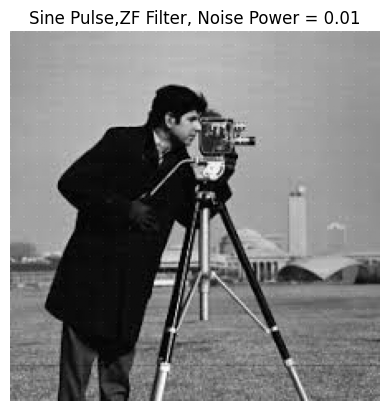

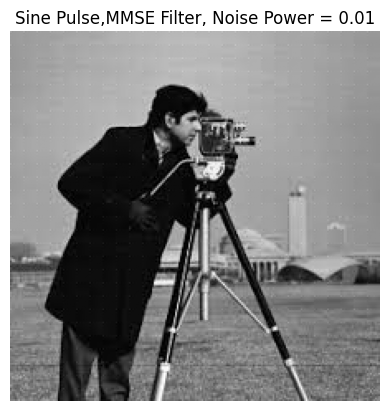

In [49]:
plt.imshow(reconstructed_img_sine_zf,cmap = 'gray')
plt.axis('off')
plt.title('Sine Pulse,ZF Filter, Noise Power = 0.01', fontsize=12)
plt.show()
plt.imshow(reconstructed_img_sine_mmse,cmap = 'gray')
plt.axis('off')
plt.title('Sine Pulse,MMSE Filter, Noise Power = 0.01', fontsize=12)
plt.show()